In [62]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [63]:
df = pd.read_csv('./nikkei.csv')
df.set_index('Date', inplace=True)
df.shape

(4615, 6)

In [64]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-01-06,8761.780273,8669.889648,8669.889648,8713.330078,23300000.0,8713.330078
2003-01-07,8829.059570,8654.519531,8810.740234,8656.500000,48100000.0,8656.500000
2003-01-08,8614.410156,8491.490234,8614.410156,8517.799805,38000000.0,8517.799805
2003-01-09,8498.030273,8400.589844,8440.320312,8497.929688,39500000.0,8497.929688
2003-01-10,8569.849609,8378.179688,8563.379883,8470.450195,49500000.0,8470.450195


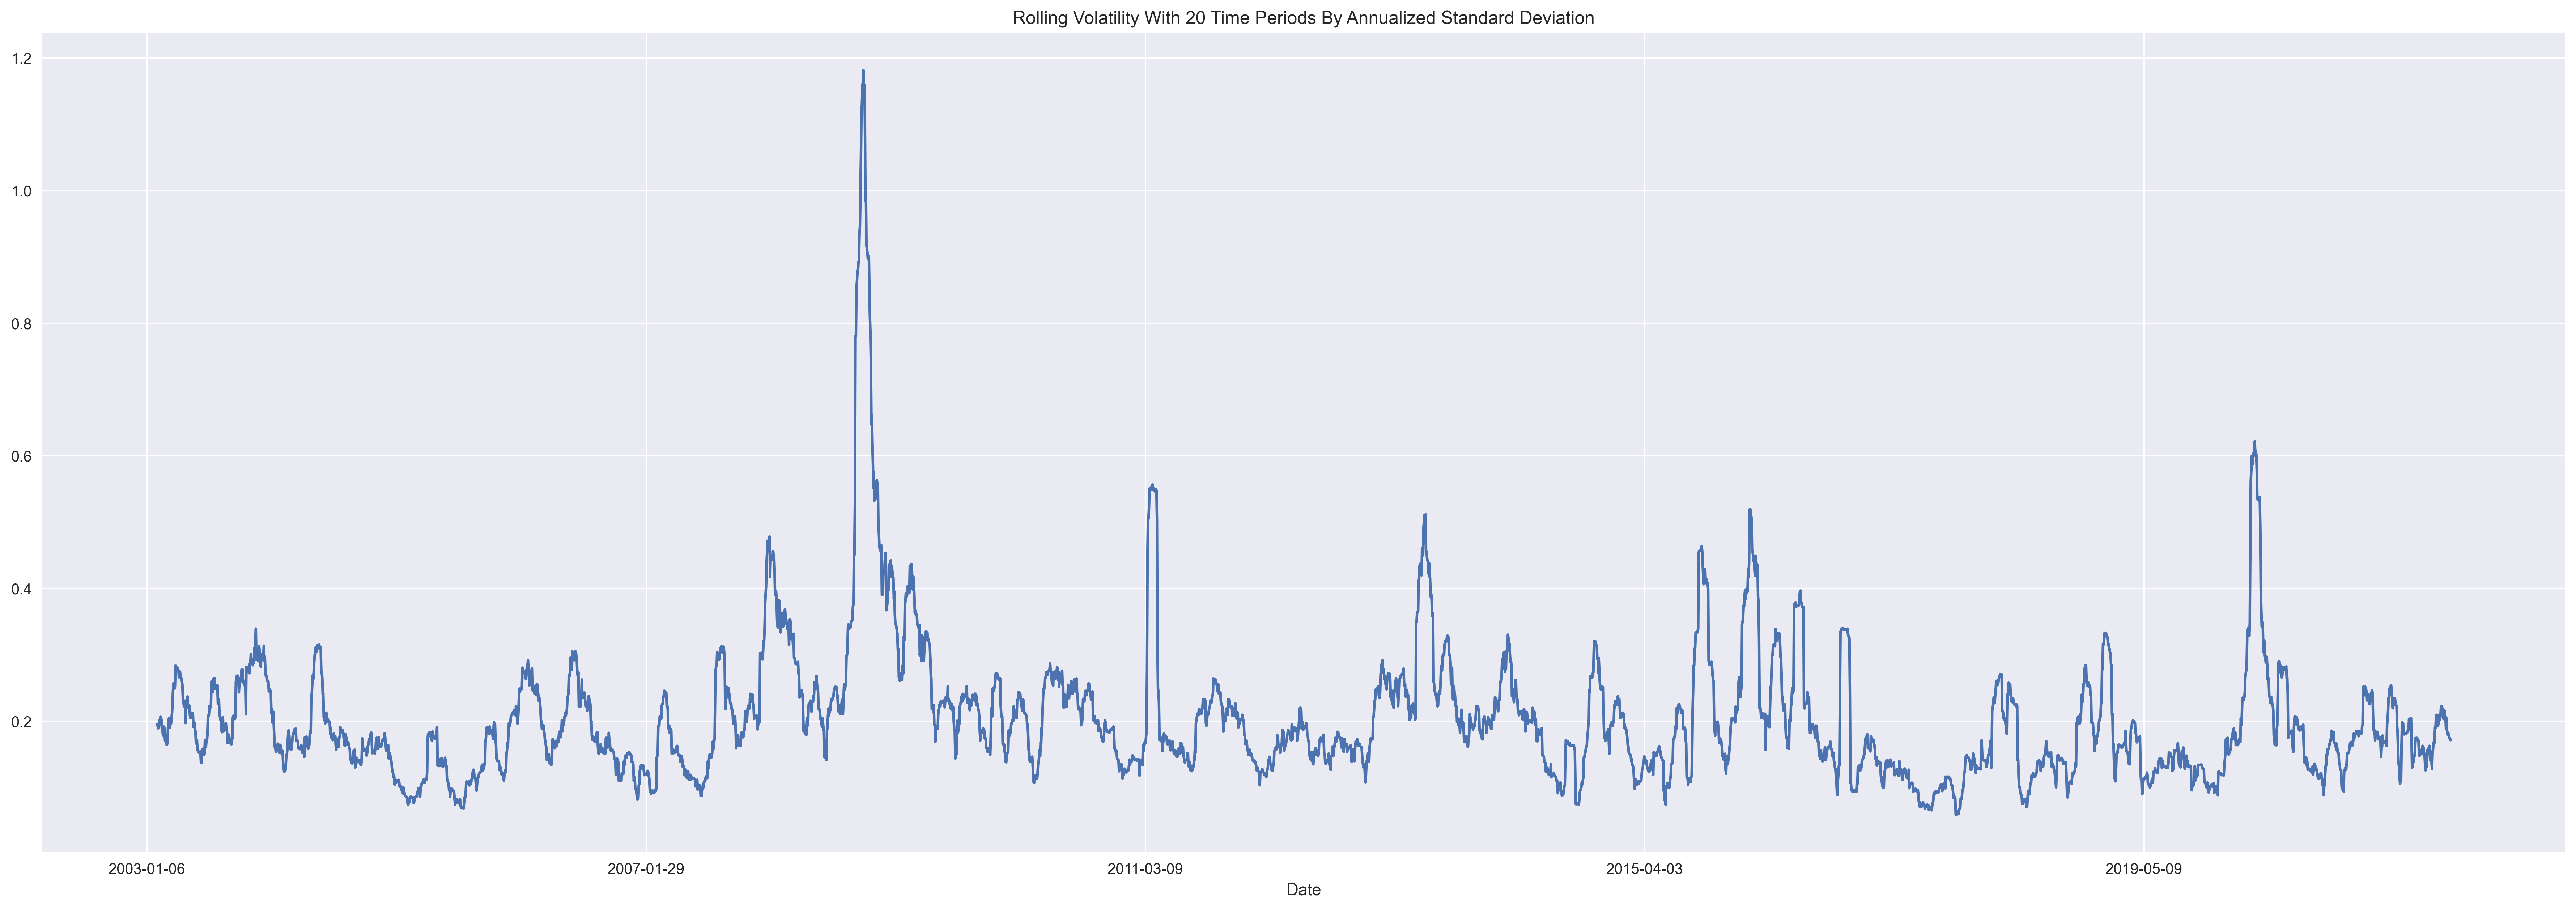

In [65]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)

df['HV'].plot(figsize=(30, 10))
plt.title('Rolling Volatility With 20 Time Periods By Annualized Standard Deviation')
plt.show()

In [66]:
df = df.loc['2003-09-29':'2021-09-28', 'STDEV':'HV']
print(df.shape)
df.head()

(4401, 3)


,STDEV,STDEV_log,HV
Date,,,
2003-09-29,233.297609,5.452315,0.268689
2003-09-30,243.013960,5.493119,0.265291
2003-10-01,250.924890,5.525154,0.243503
2003-10-02,250.737225,5.524405,0.257628
2003-10-03,250.631256,5.523983,0.260587


In [67]:
array = df.values
window_size = 20

X_std     = []
X_std_log = []
X_hv      = []

y_std     = []
y_std_log = []
y_hv      = []

for i in range(df.shape[0] - window_size):
    X_std.append(array[i:i + window_size, 0])
    X_std_log.append(array[i:i + window_size, 1])
    X_hv.append(array[i:i + window_size, 2])
    y_std.append(array[i + window_size, 0])
    y_std_log.append(array[i + window_size, 1])
    y_hv.append(array[i + window_size, 2])

In [68]:
X = []
for i in [X_std, X_std_log, X_hv]:
    X.append(np.array(i))

y = []
for i in [y_std, y_std_log, y_hv]:
    y.append(np.array(i))

for i, j in zip(X, y):
    print(i.shape, j.shape)

(4381, 20) (4381,)
(4381, 20) (4381,)
(4381, 20) (4381,)


In [69]:
test_size = df.loc['2020-09-29':].shape[0] - window_size
test_size

224

In [70]:
df[:-20].iloc[-test_size:]

,STDEV,STDEV_log,HV
Date,,,
2020-09-29,159.170883,5.069978,0.119761
2020-09-30,157.114740,5.056976,0.127338
2020-10-02,164.522194,5.103045,0.129626
2020-10-05,164.057054,5.100214,0.136026
2020-10-06,162.639495,5.091536,0.133046
...,...,...,...
2021-08-23,269.805561,5.597702,0.162897
2021-08-24,267.522038,5.589202,0.161560
2021-08-25,258.435196,5.554645,0.160454


In [71]:
df[:-20].iloc[:-test_size]

,STDEV,STDEV_log,HV
Date,,,
2003-09-29,233.297609,5.452315,0.268689
2003-09-30,243.013960,5.493119,0.265291
2003-10-01,250.924890,5.525154,0.243503
2003-10-02,250.737225,5.524405,0.257628
2003-10-03,250.631256,5.523983,0.260587
...,...,...,...
2020-09-18,171.321475,5.143542,0.125109
2020-09-23,160.839371,5.080406,0.125025
2020-09-24,165.573718,5.109417,0.122285


In [72]:
X_train = []
y_train = []
X_test  = []
y_test  = []
for i, j in zip(X, y):
    X_train.append(np.expand_dims(i[:-test_size], axis=-1))
    y_train.append(np.expand_dims(j[:-test_size], axis=-1))
    X_test.append(np.expand_dims(i[-test_size:], axis=-1))
    y_test.append(np.expand_dims(j[-test_size:], axis=-1))

In [73]:
X_train[0].shape, y_train[0].shape, X_test[0].shape, y_test[0].shape

((4157, 20, 1), (4157, 1), (224, 20, 1), (224, 1))

In [74]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional

histories = []
models    = []
for i, j, k, l in zip(X_train, y_train, X_test, y_test):
    
    input  = Input(batch_shape=(None, X_train[0].shape[1], X_train[0].shape[2]))
    lstm1  = LSTM(units=10, return_sequences=True)(input)
    lstm2  = Bidirectional(LSTM(units=10))(lstm1)
    output = Dense(units=1)(lstm2)
    
    model = Model(input, output)
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(i, j, validation_data=(k, l), epochs=5, batch_size=20, verbose=1)
    models.append(model)
    histories.append(history)

Epoch 1/5
208/208 [==============================] - 6s 12ms/step - loss: 134462.1094 - val_loss: 312142.1875
Epoch 2/5
208/208 [==============================] - 2s 9ms/step - loss: 129721.2891 - val_loss: 306059.0625
Epoch 3/5
208/208 [==============================] - 2s 9ms/step - loss: 126529.3203 - val_loss: 301224.0000
Epoch 4/5
208/208 [==============================] - 2s 9ms/step - loss: 123773.6562 - val_loss: 296736.9688
Epoch 5/5
208/208 [==============================] - 2s 9ms/step - loss: 121184.6875 - val_loss: 292439.4688
Epoch 1/5
208/208 [==============================] - 5s 13ms/step - loss: 6.1516 - val_loss: 0.5294
Epoch 2/5
208/208 [==============================] - 2s 9ms/step - loss: 0.2872 - val_loss: 0.5039
Epoch 3/5
208/208 [==============================] - 2s 9ms/step - loss: 0.2846 - val_loss: 0.5205
Epoch 4/5
208/208 [==============================] - 2s 9ms/step - loss: 0.2617 - val_loss: 0.3494
Epoch 5/5
208/208 [==============================] - 2s 9

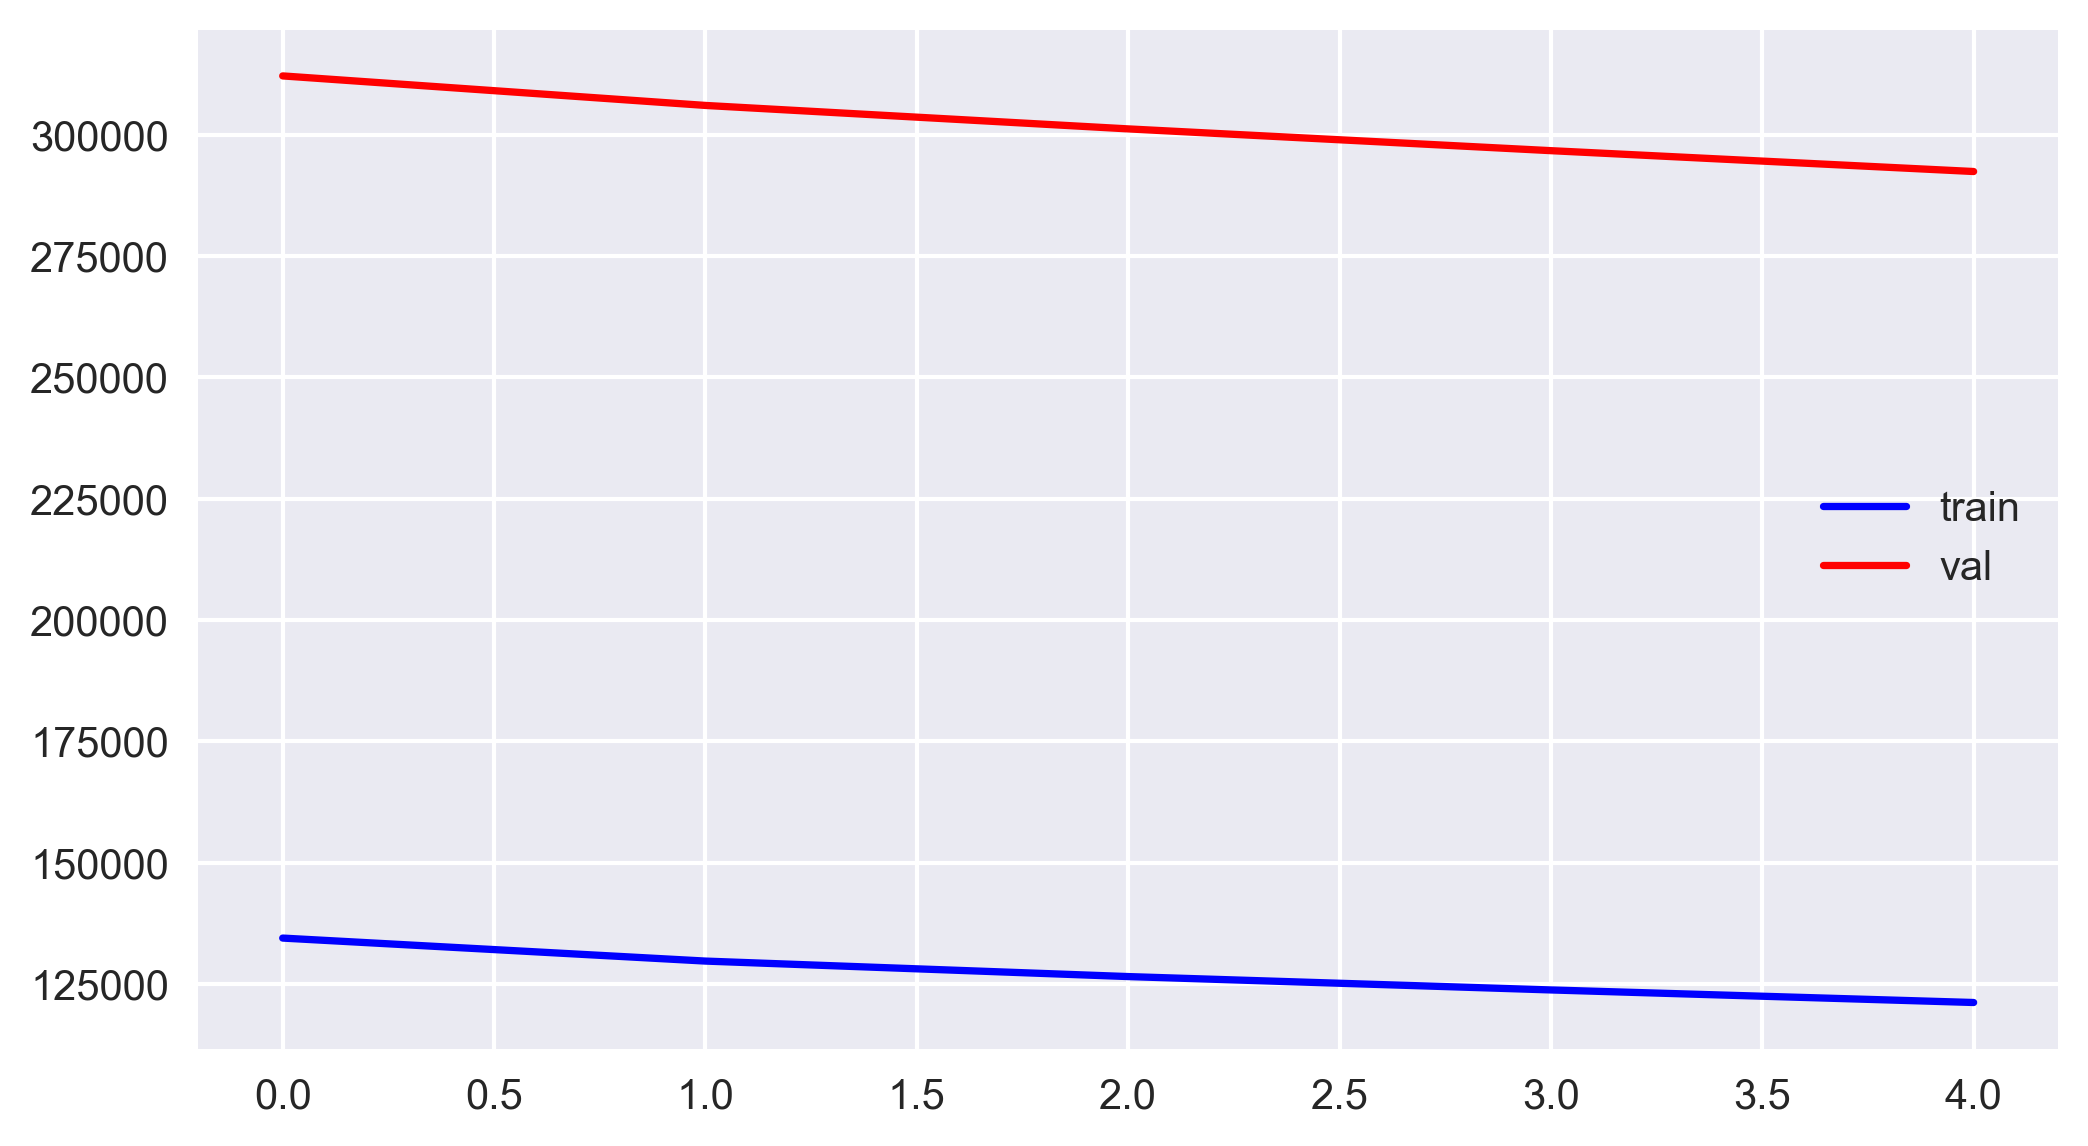

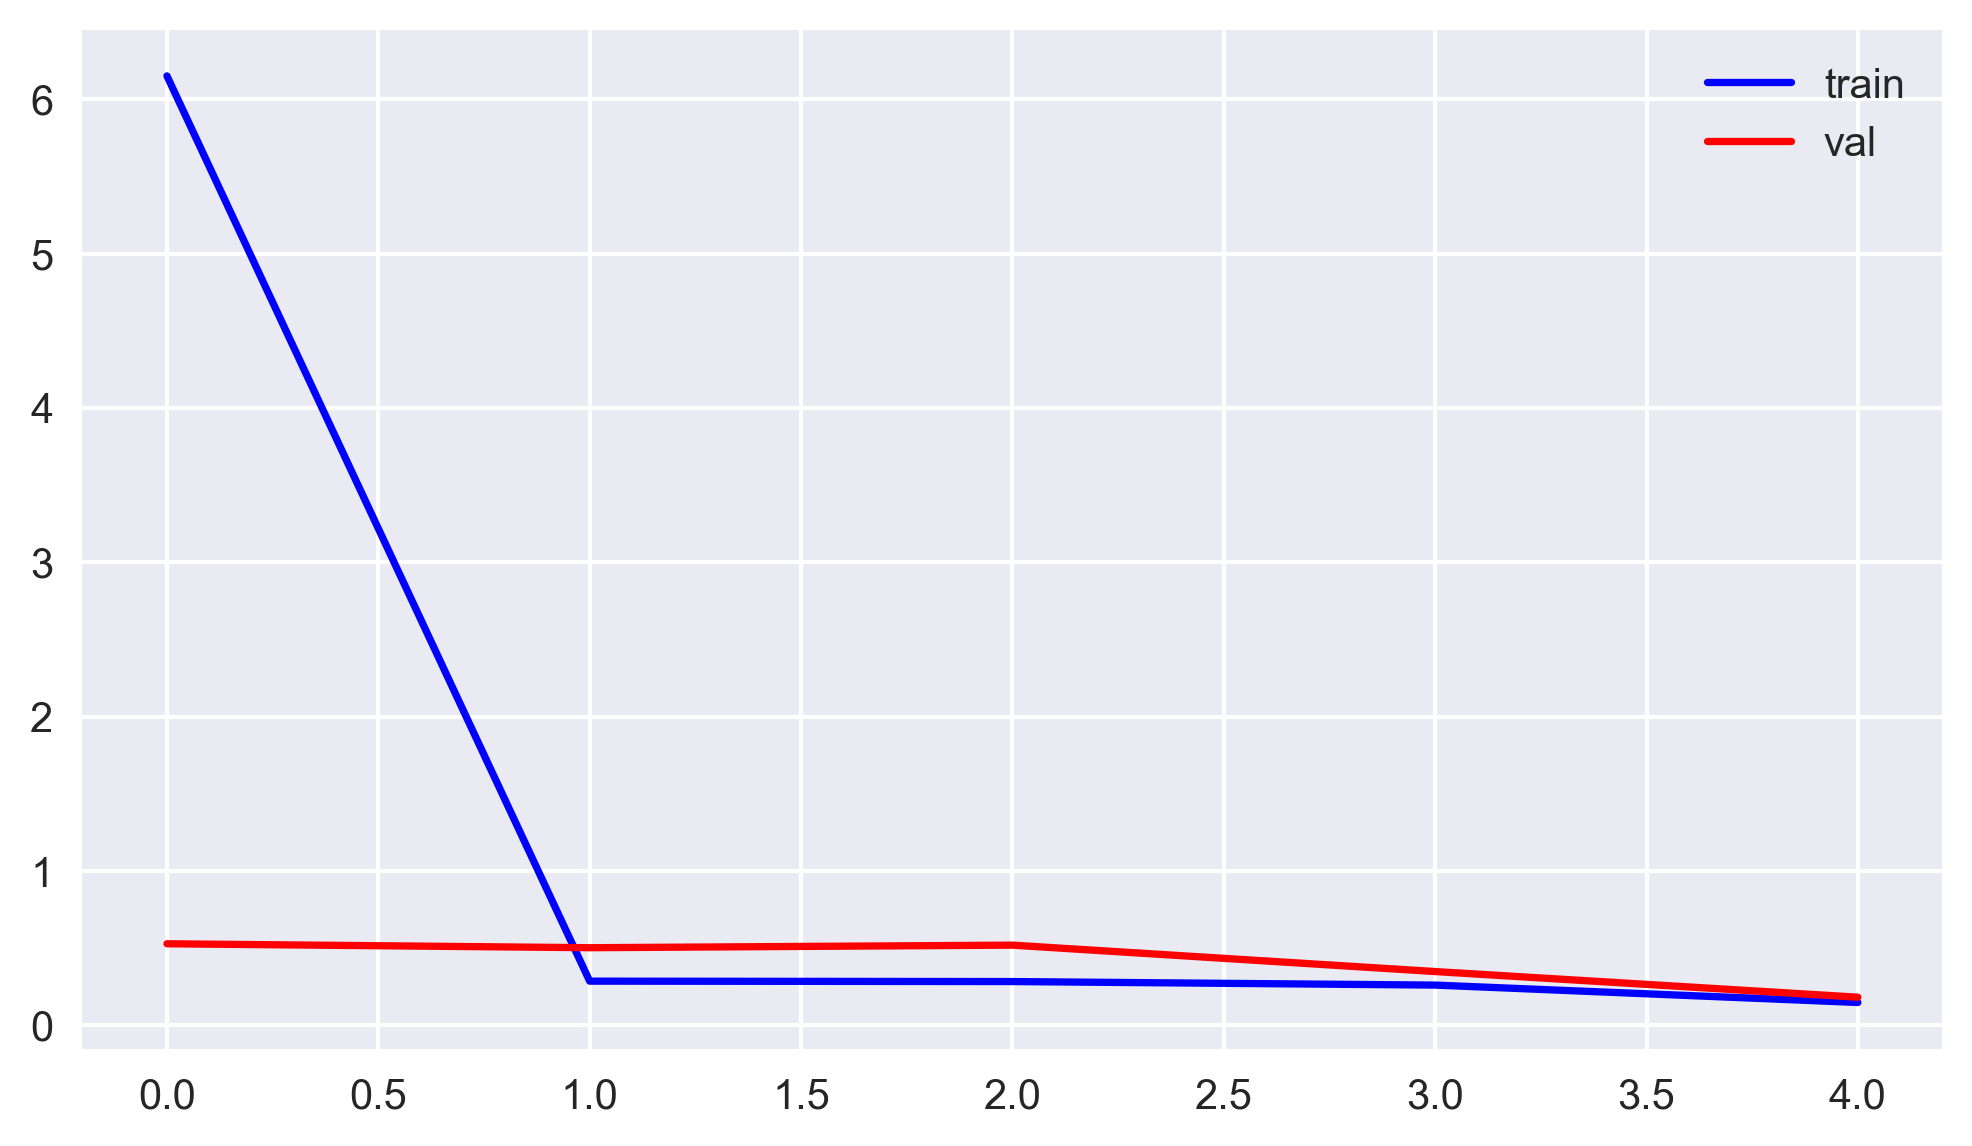

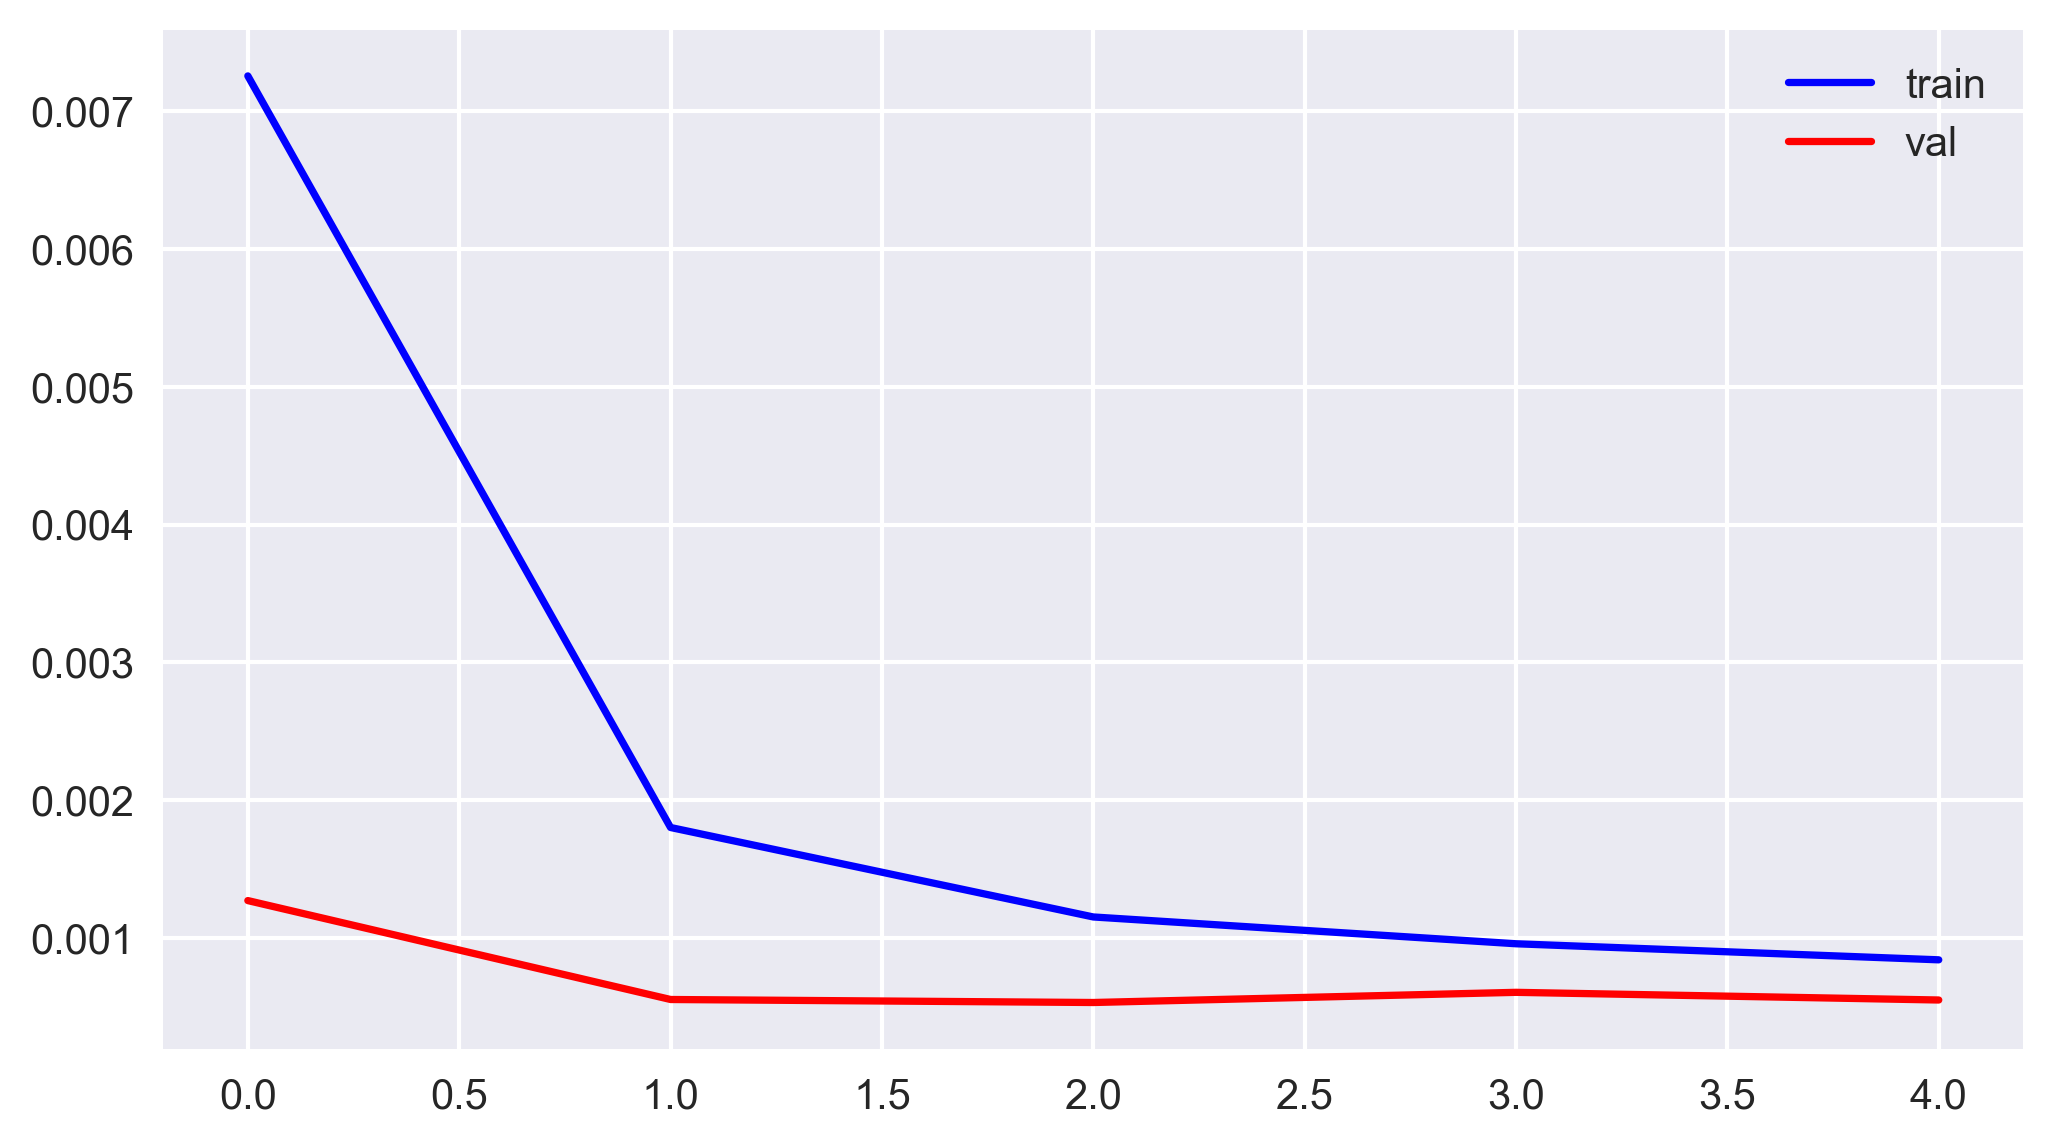

In [75]:
for h in histories:
    train_loss = h.history['loss']
    val_loss   = h.history['val_loss']
    plt.plot(range(len(train_loss)), train_loss, c='b', label='train')
    plt.plot(range(len(val_loss)), val_loss, c='r', label='val')
    plt.legend()
    plt.show()

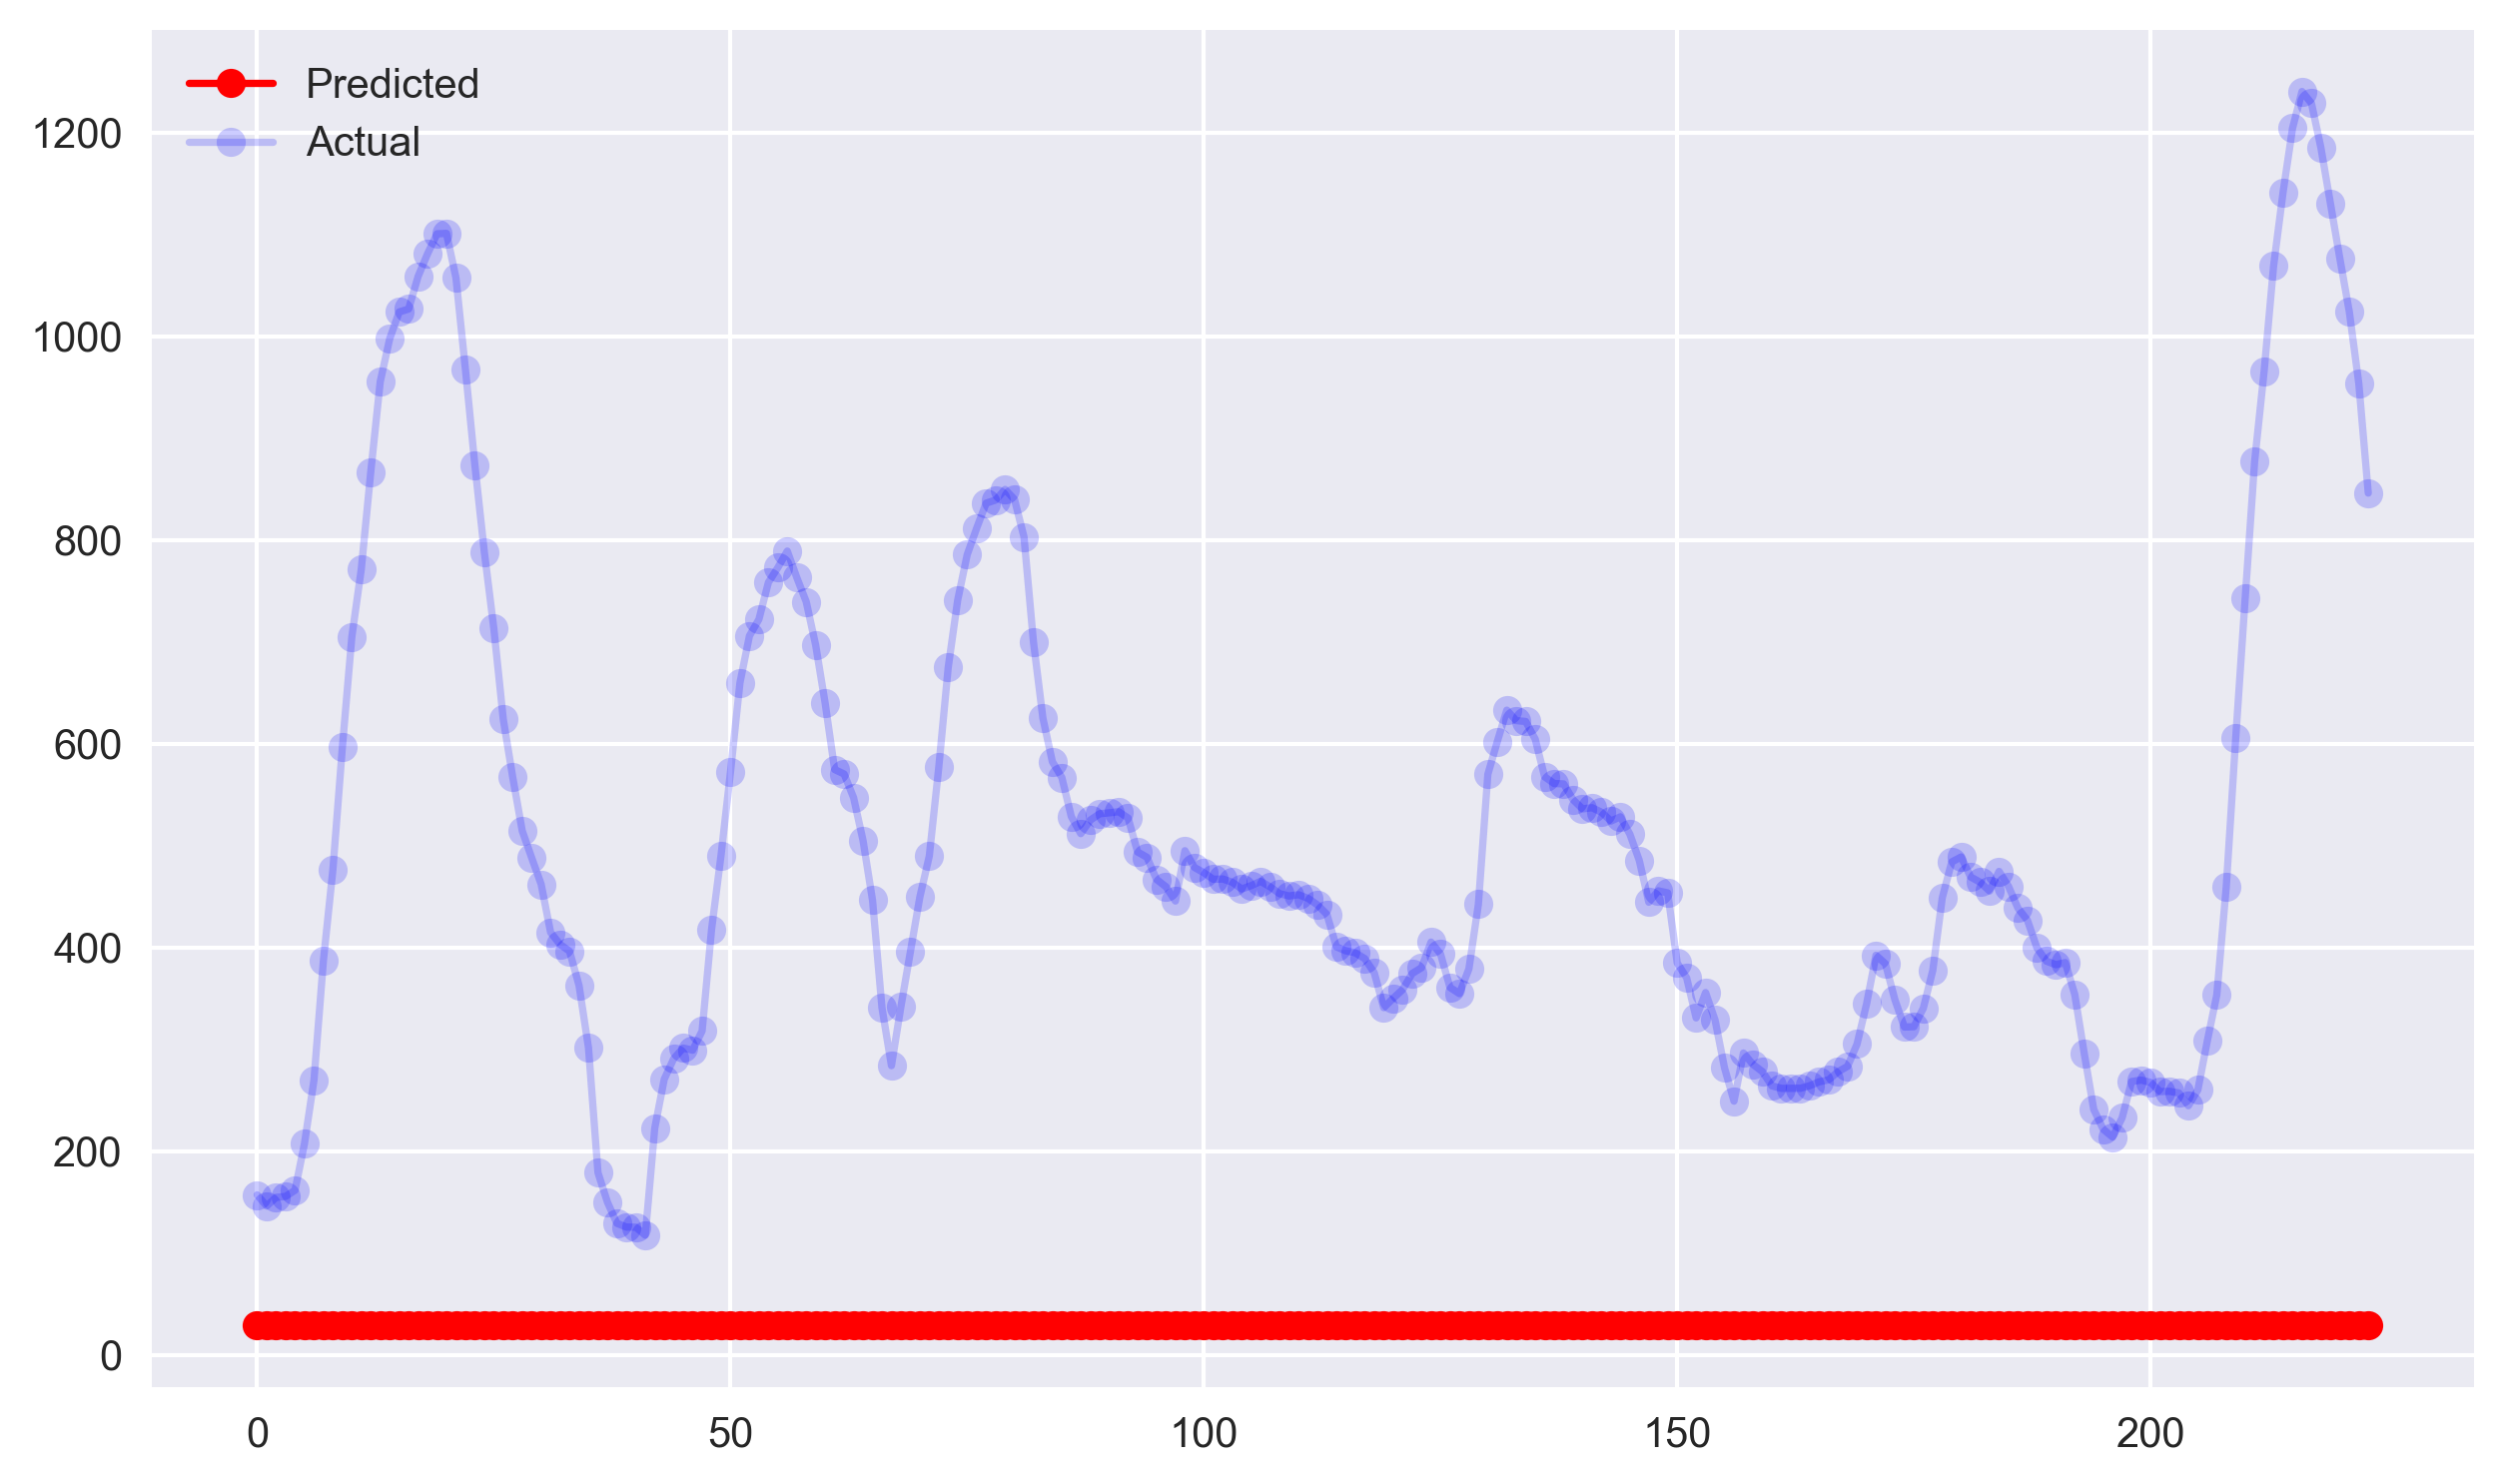

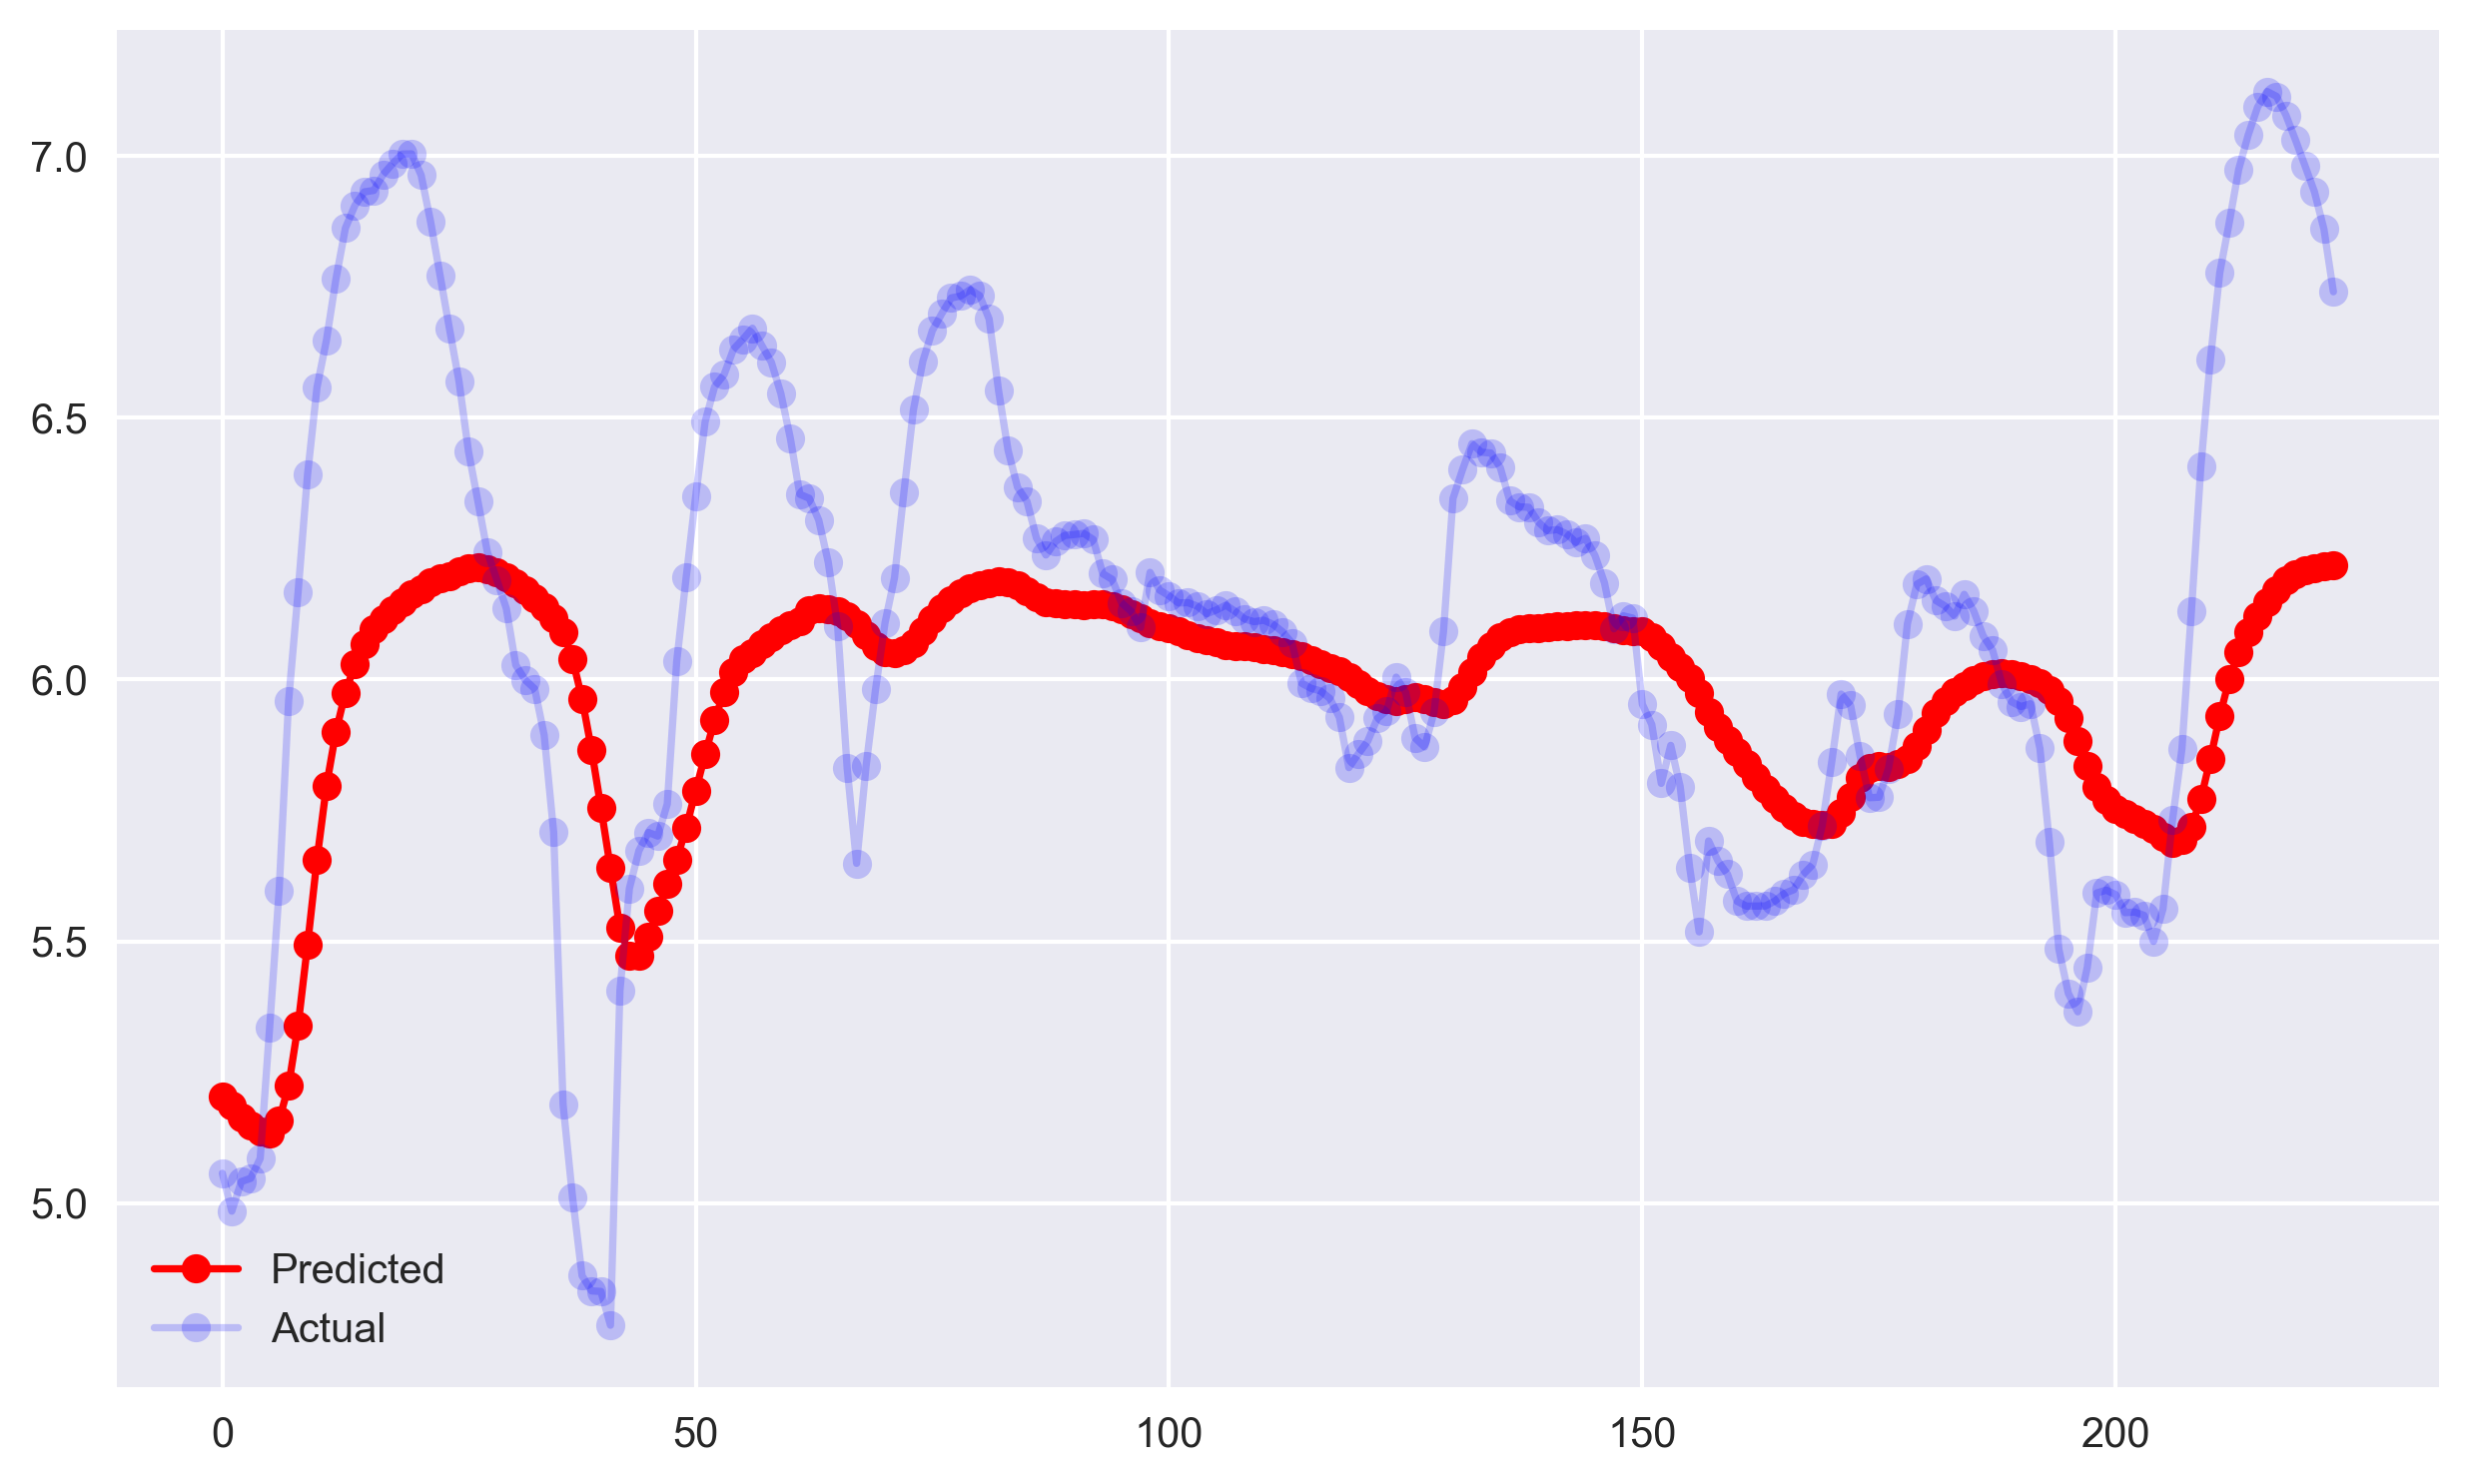

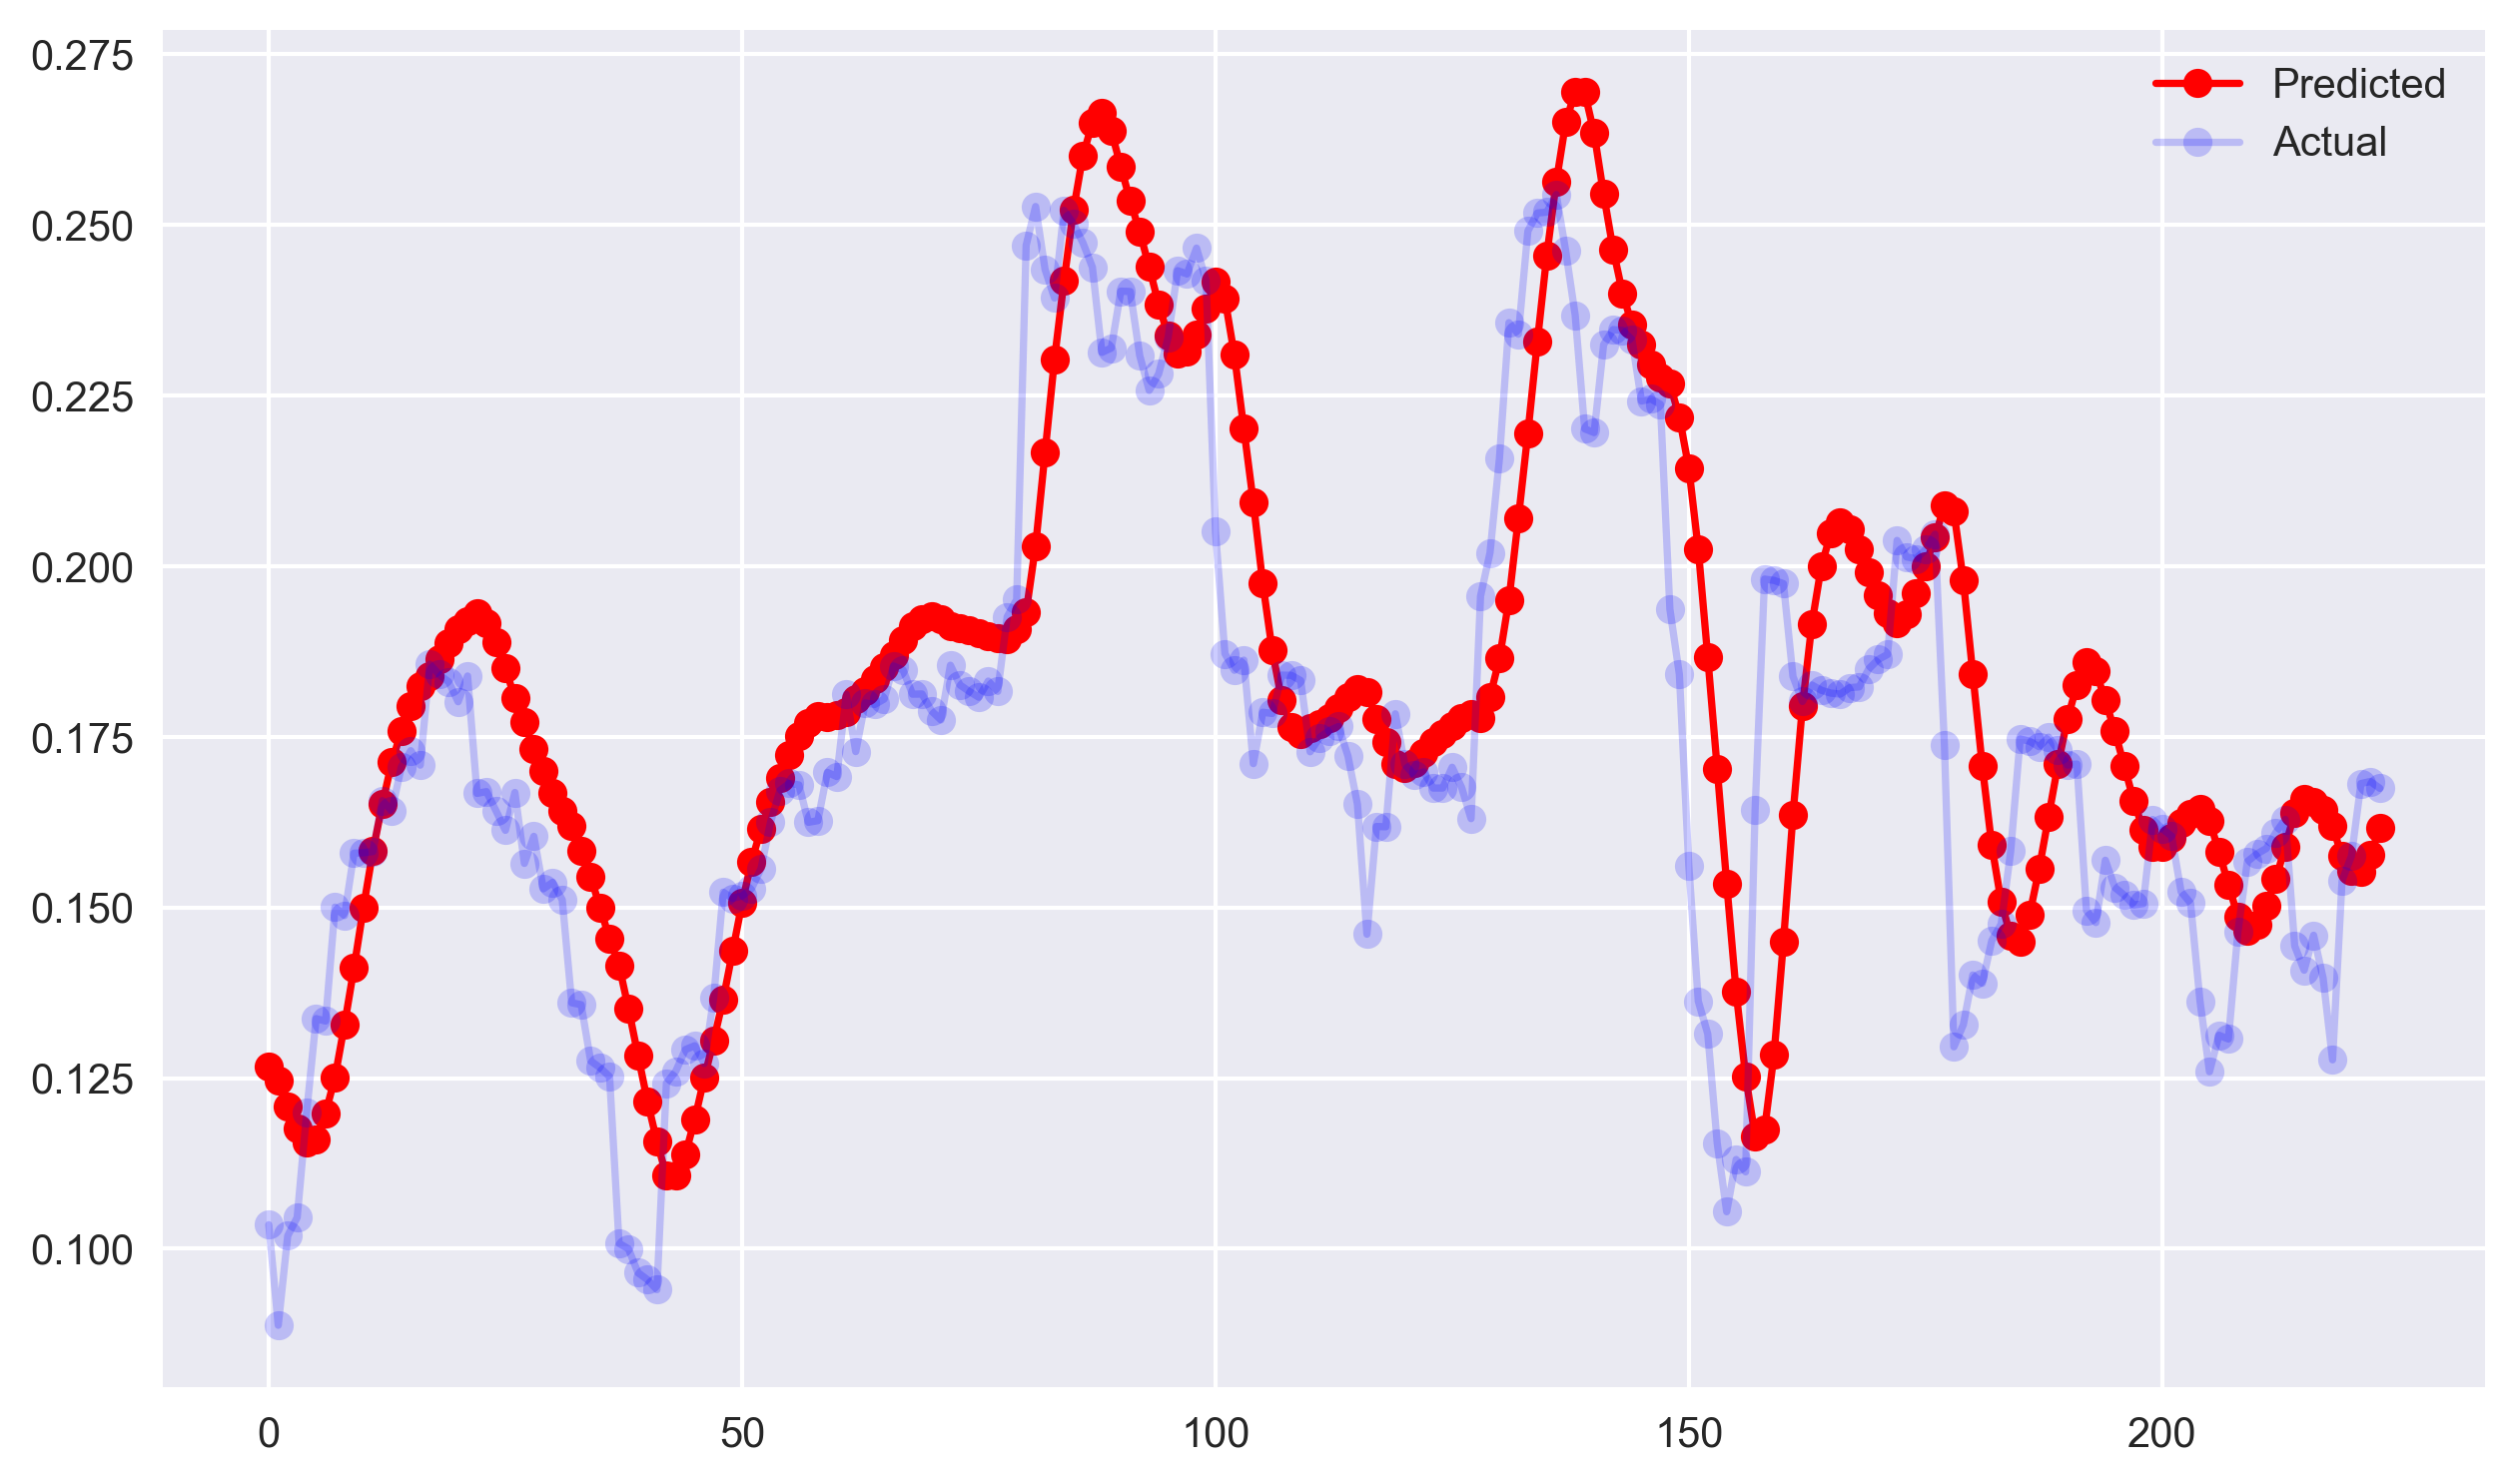

In [76]:
y_hat = []
for i, j in zip(models, X_test):
    y_hat.append(i.predict(j, batch_size=1))

for i, j in zip(y_hat, y_test):
    a_axis = np.arange(0, i.shape[0])
    b_axis = np.arange(0, j.shape[0])
    plt.figure(figsize=(10,6))
    plt.plot(b_axis, i.reshape(i.shape[0],), 'o-', color='red', label='Predicted')
    plt.plot(b_axis, j.reshape(j.shape[0],), 'o-', color='blue', alpha=0.2, label='Actual')
    plt.legend()
    plt.show()

In [77]:
for i in histories:
    print(np.mean(np.sqrt(i.history['val_loss'])))

549.2548208064226
0.6355919908628306
0.026001019193820623


In [78]:
from keras.layers import GRU

histories = []
models    = []
for i, j, k, l in zip(X_train, y_train, X_test, y_test):
    
    input  = Input(batch_shape=(None, X_train[0].shape[1], X_train[0].shape[2]))
    gru    = GRU(units=10, return_sequences=False)(input)
    output = Dense(units=1)(gru)
    
    model = Model(input, output)
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(i, j, validation_data=(k, l), epochs=5, batch_size=20, verbose=1)
    models.append(model)
    histories.append(history)

Epoch 1/5
208/208 [==============================] - 3s 6ms/step - loss: 136633.0625 - val_loss: 319522.3125
Epoch 2/5
208/208 [==============================] - 1s 5ms/step - loss: 135611.3906 - val_loss: 317912.7812
Epoch 3/5
208/208 [==============================] - 1s 5ms/step - loss: 134702.0625 - val_loss: 316461.6875
Epoch 4/5
208/208 [==============================] - 1s 5ms/step - loss: 133824.7344 - val_loss: 315018.0312
Epoch 5/5
208/208 [==============================] - 1s 5ms/step - loss: 132954.2969 - val_loss: 313585.0000
Epoch 1/5
208/208 [==============================] - 2s 6ms/step - loss: 11.9752 - val_loss: 3.2791
Epoch 2/5
208/208 [==============================] - 1s 5ms/step - loss: 0.8095 - val_loss: 0.8836
Epoch 3/5
208/208 [==============================] - 1s 5ms/step - loss: 0.2947 - val_loss: 0.5321
Epoch 4/5
208/208 [==============================] - 1s 5ms/step - loss: 0.2675 - val_loss: 0.4880
Epoch 5/5
208/208 [==============================] - 1s 5m

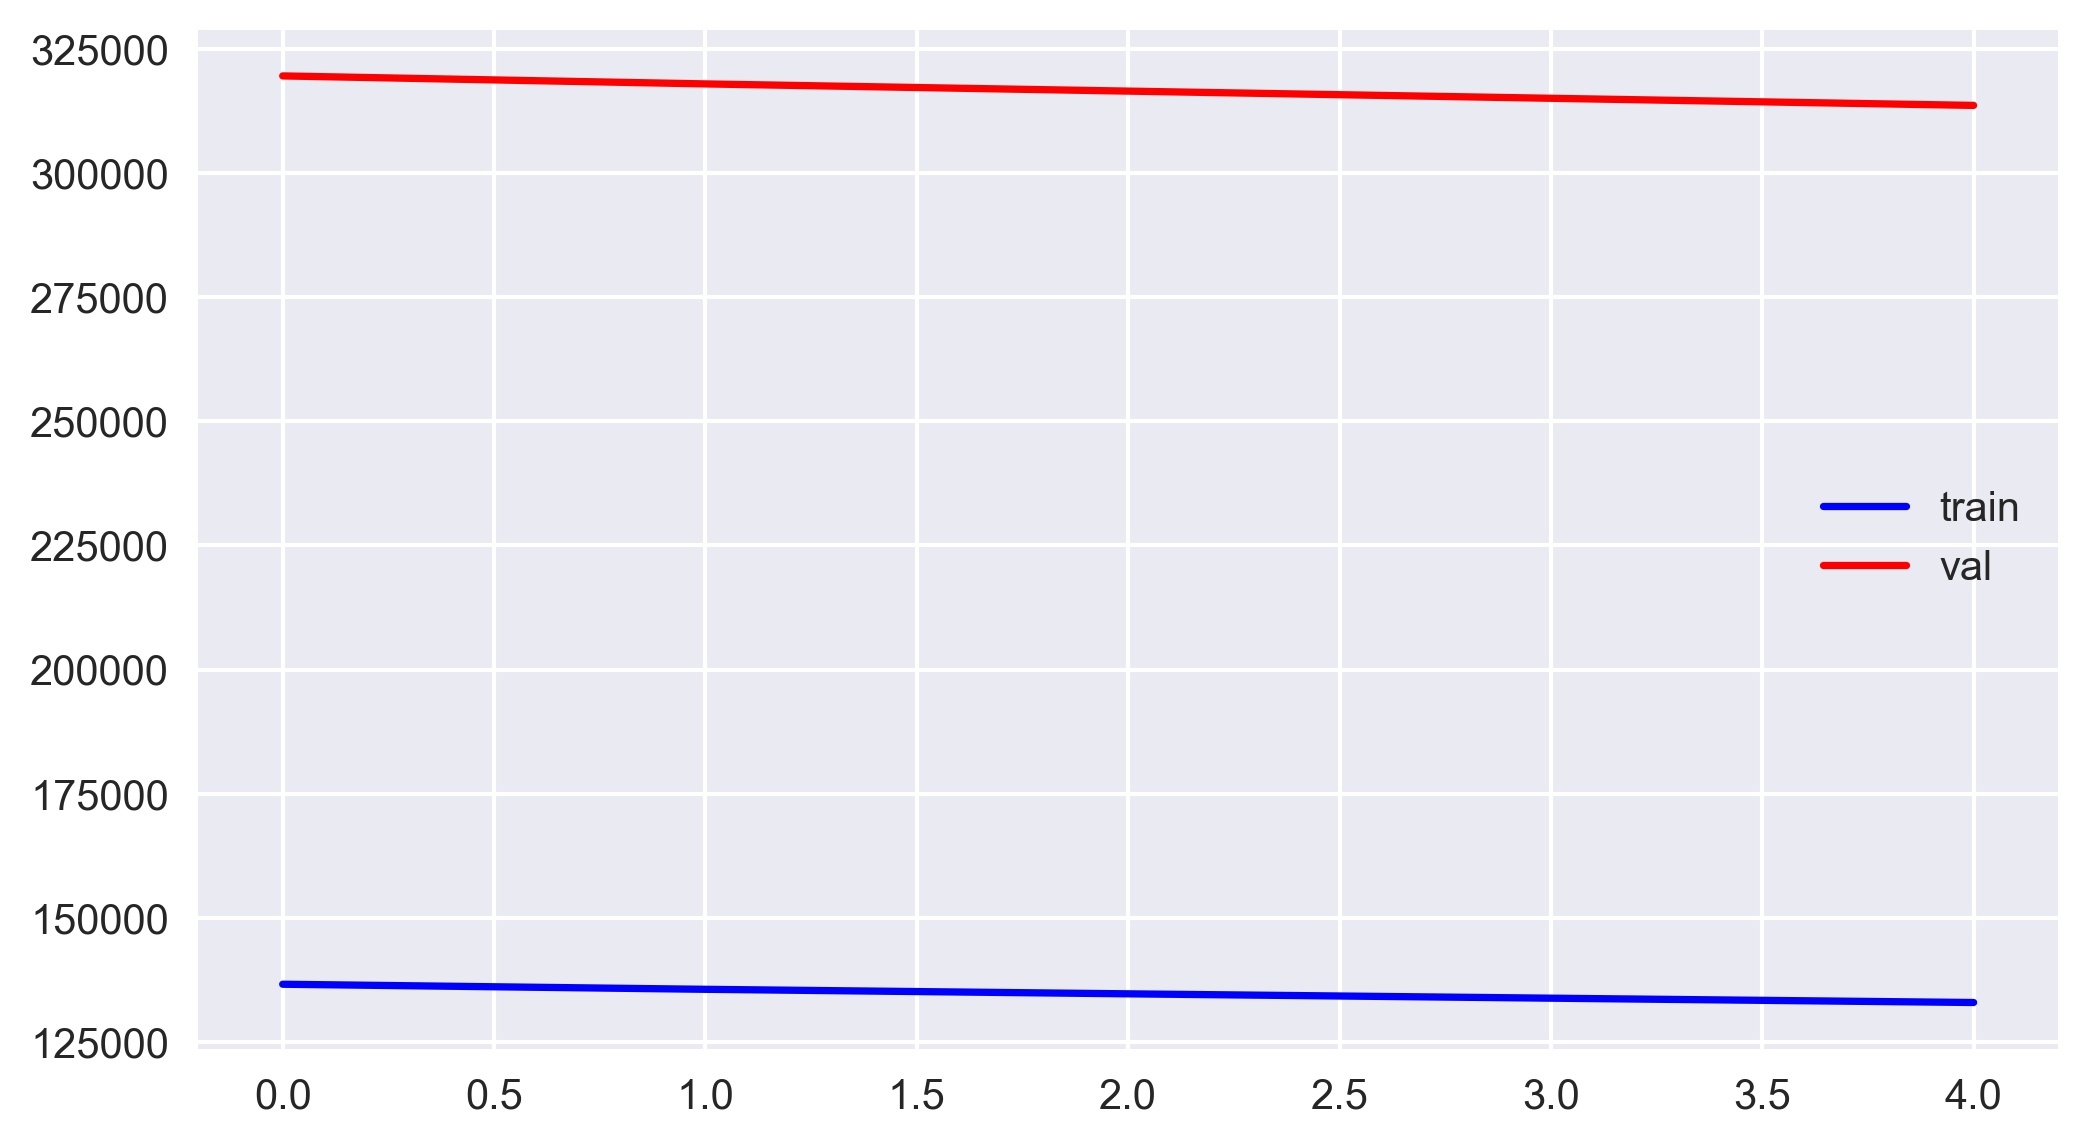

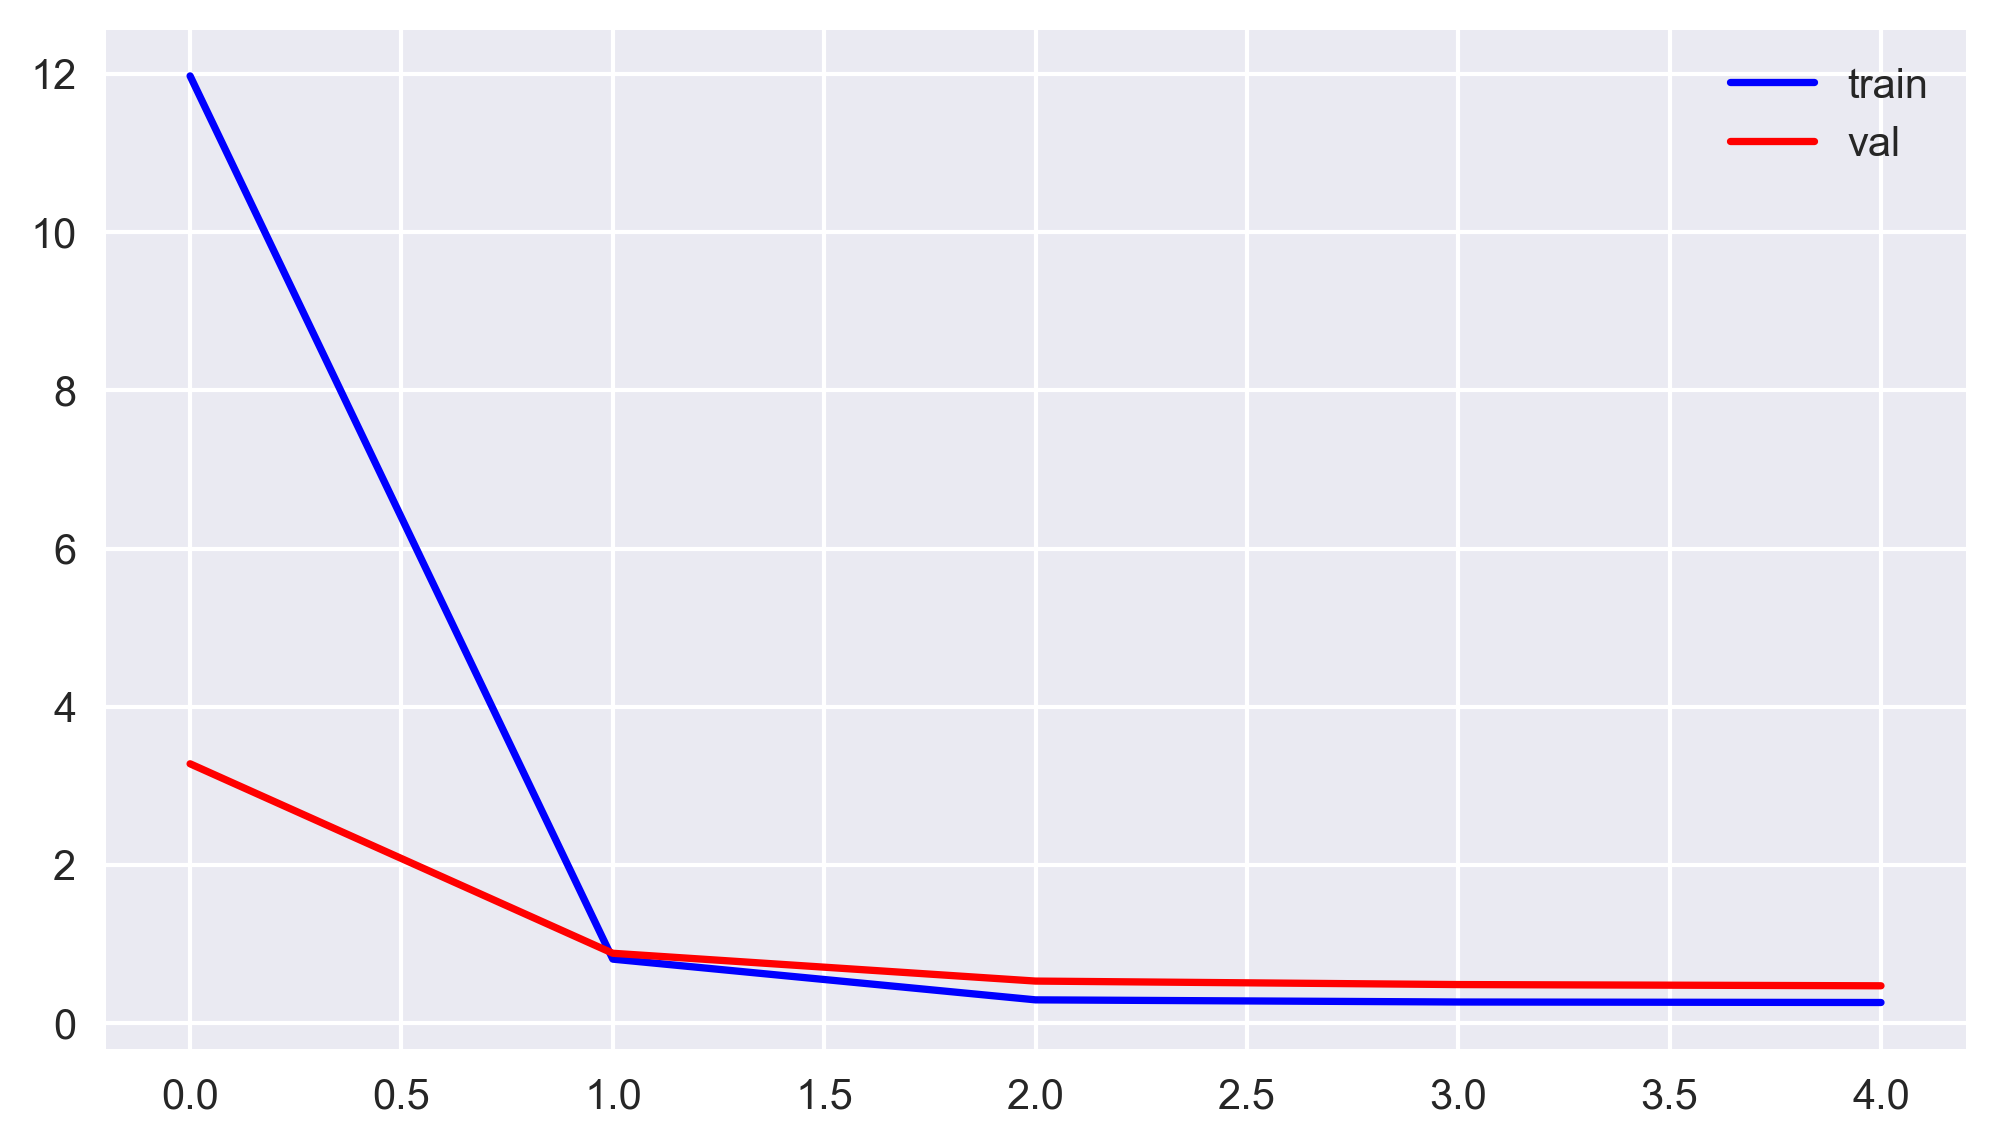

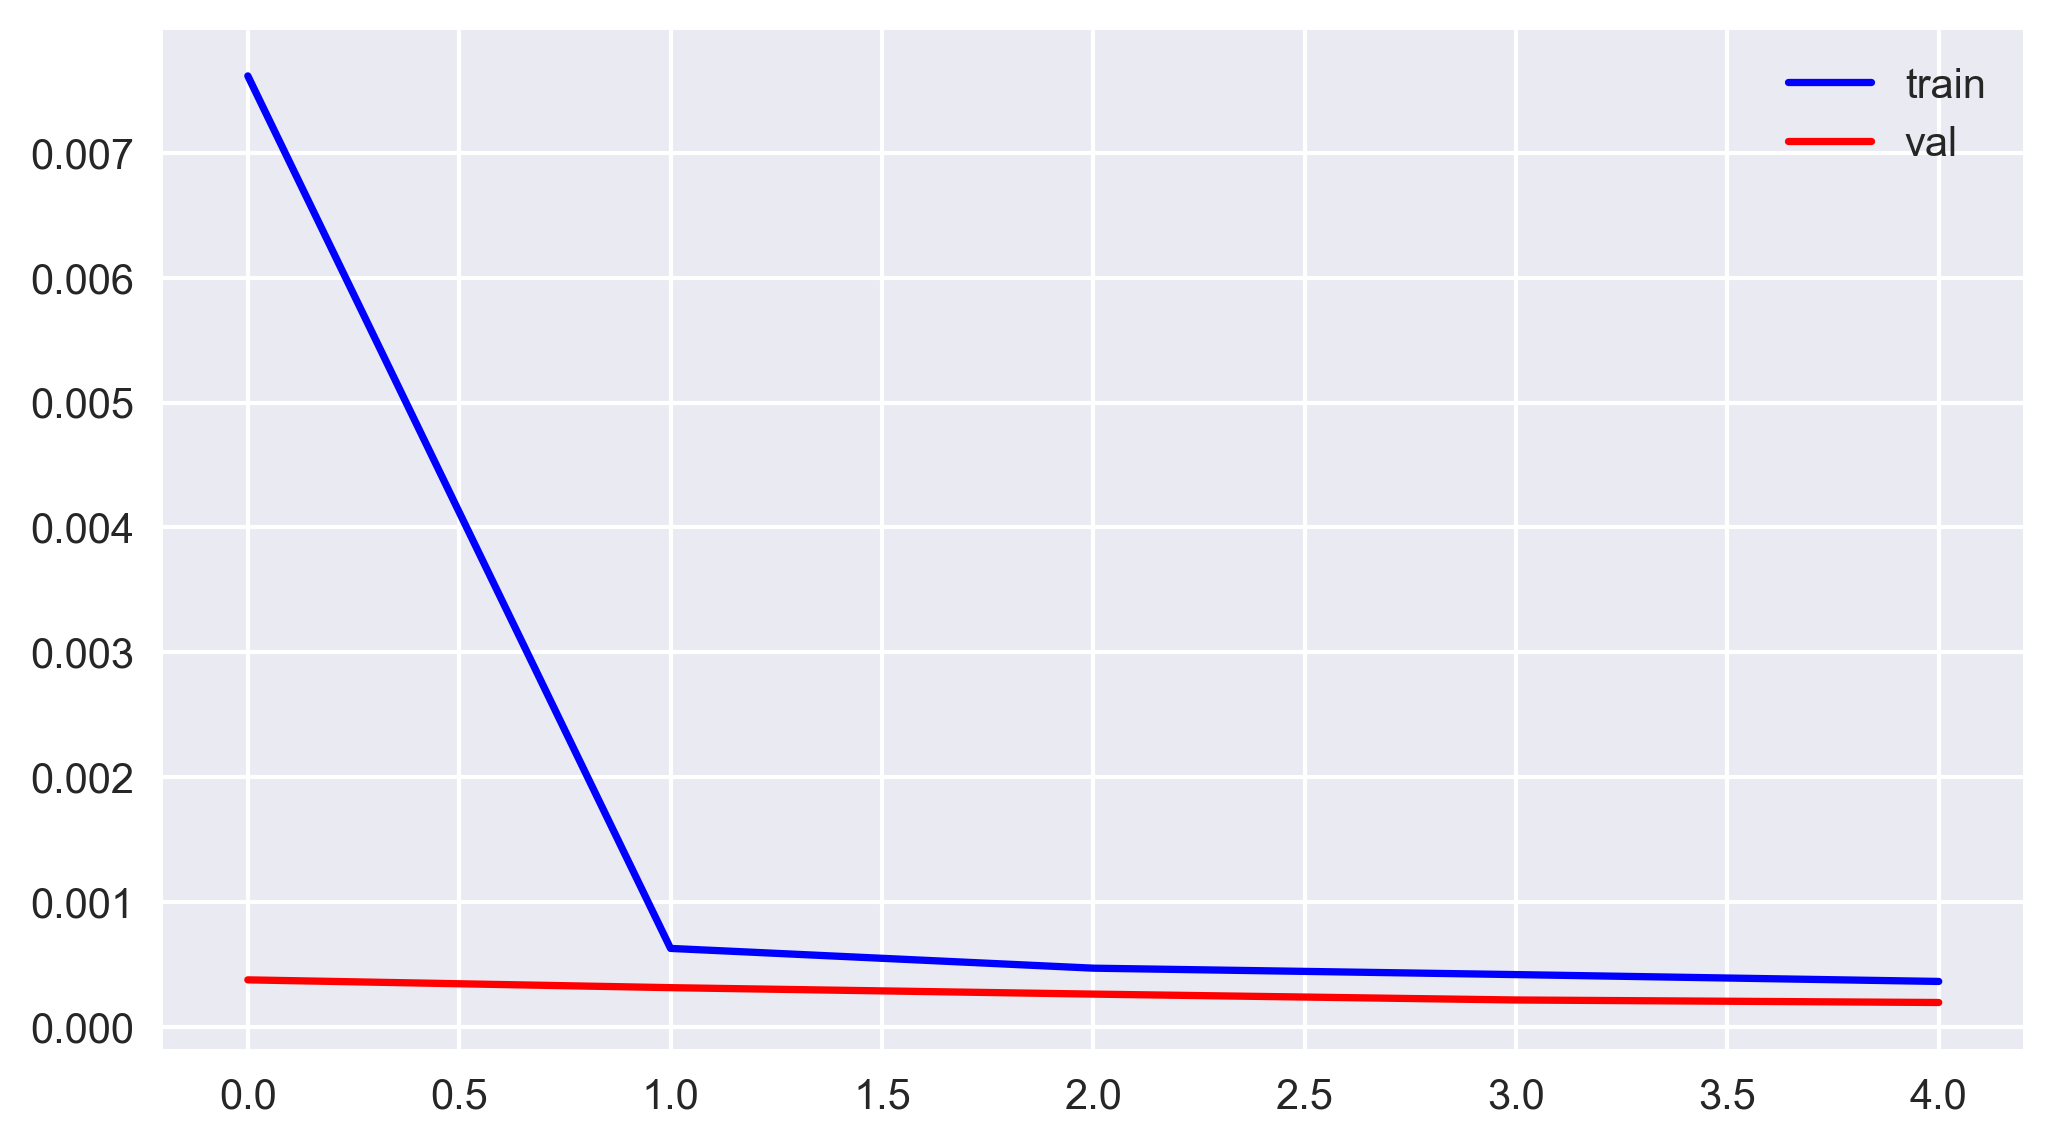

In [79]:
for h in histories:
    train_loss = h.history['loss']
    val_loss   = h.history['val_loss']
    plt.plot(range(len(train_loss)), train_loss, c='b', label='train')
    plt.plot(range(len(val_loss)), val_loss, c='r', label='val')
    plt.legend()
    plt.show()

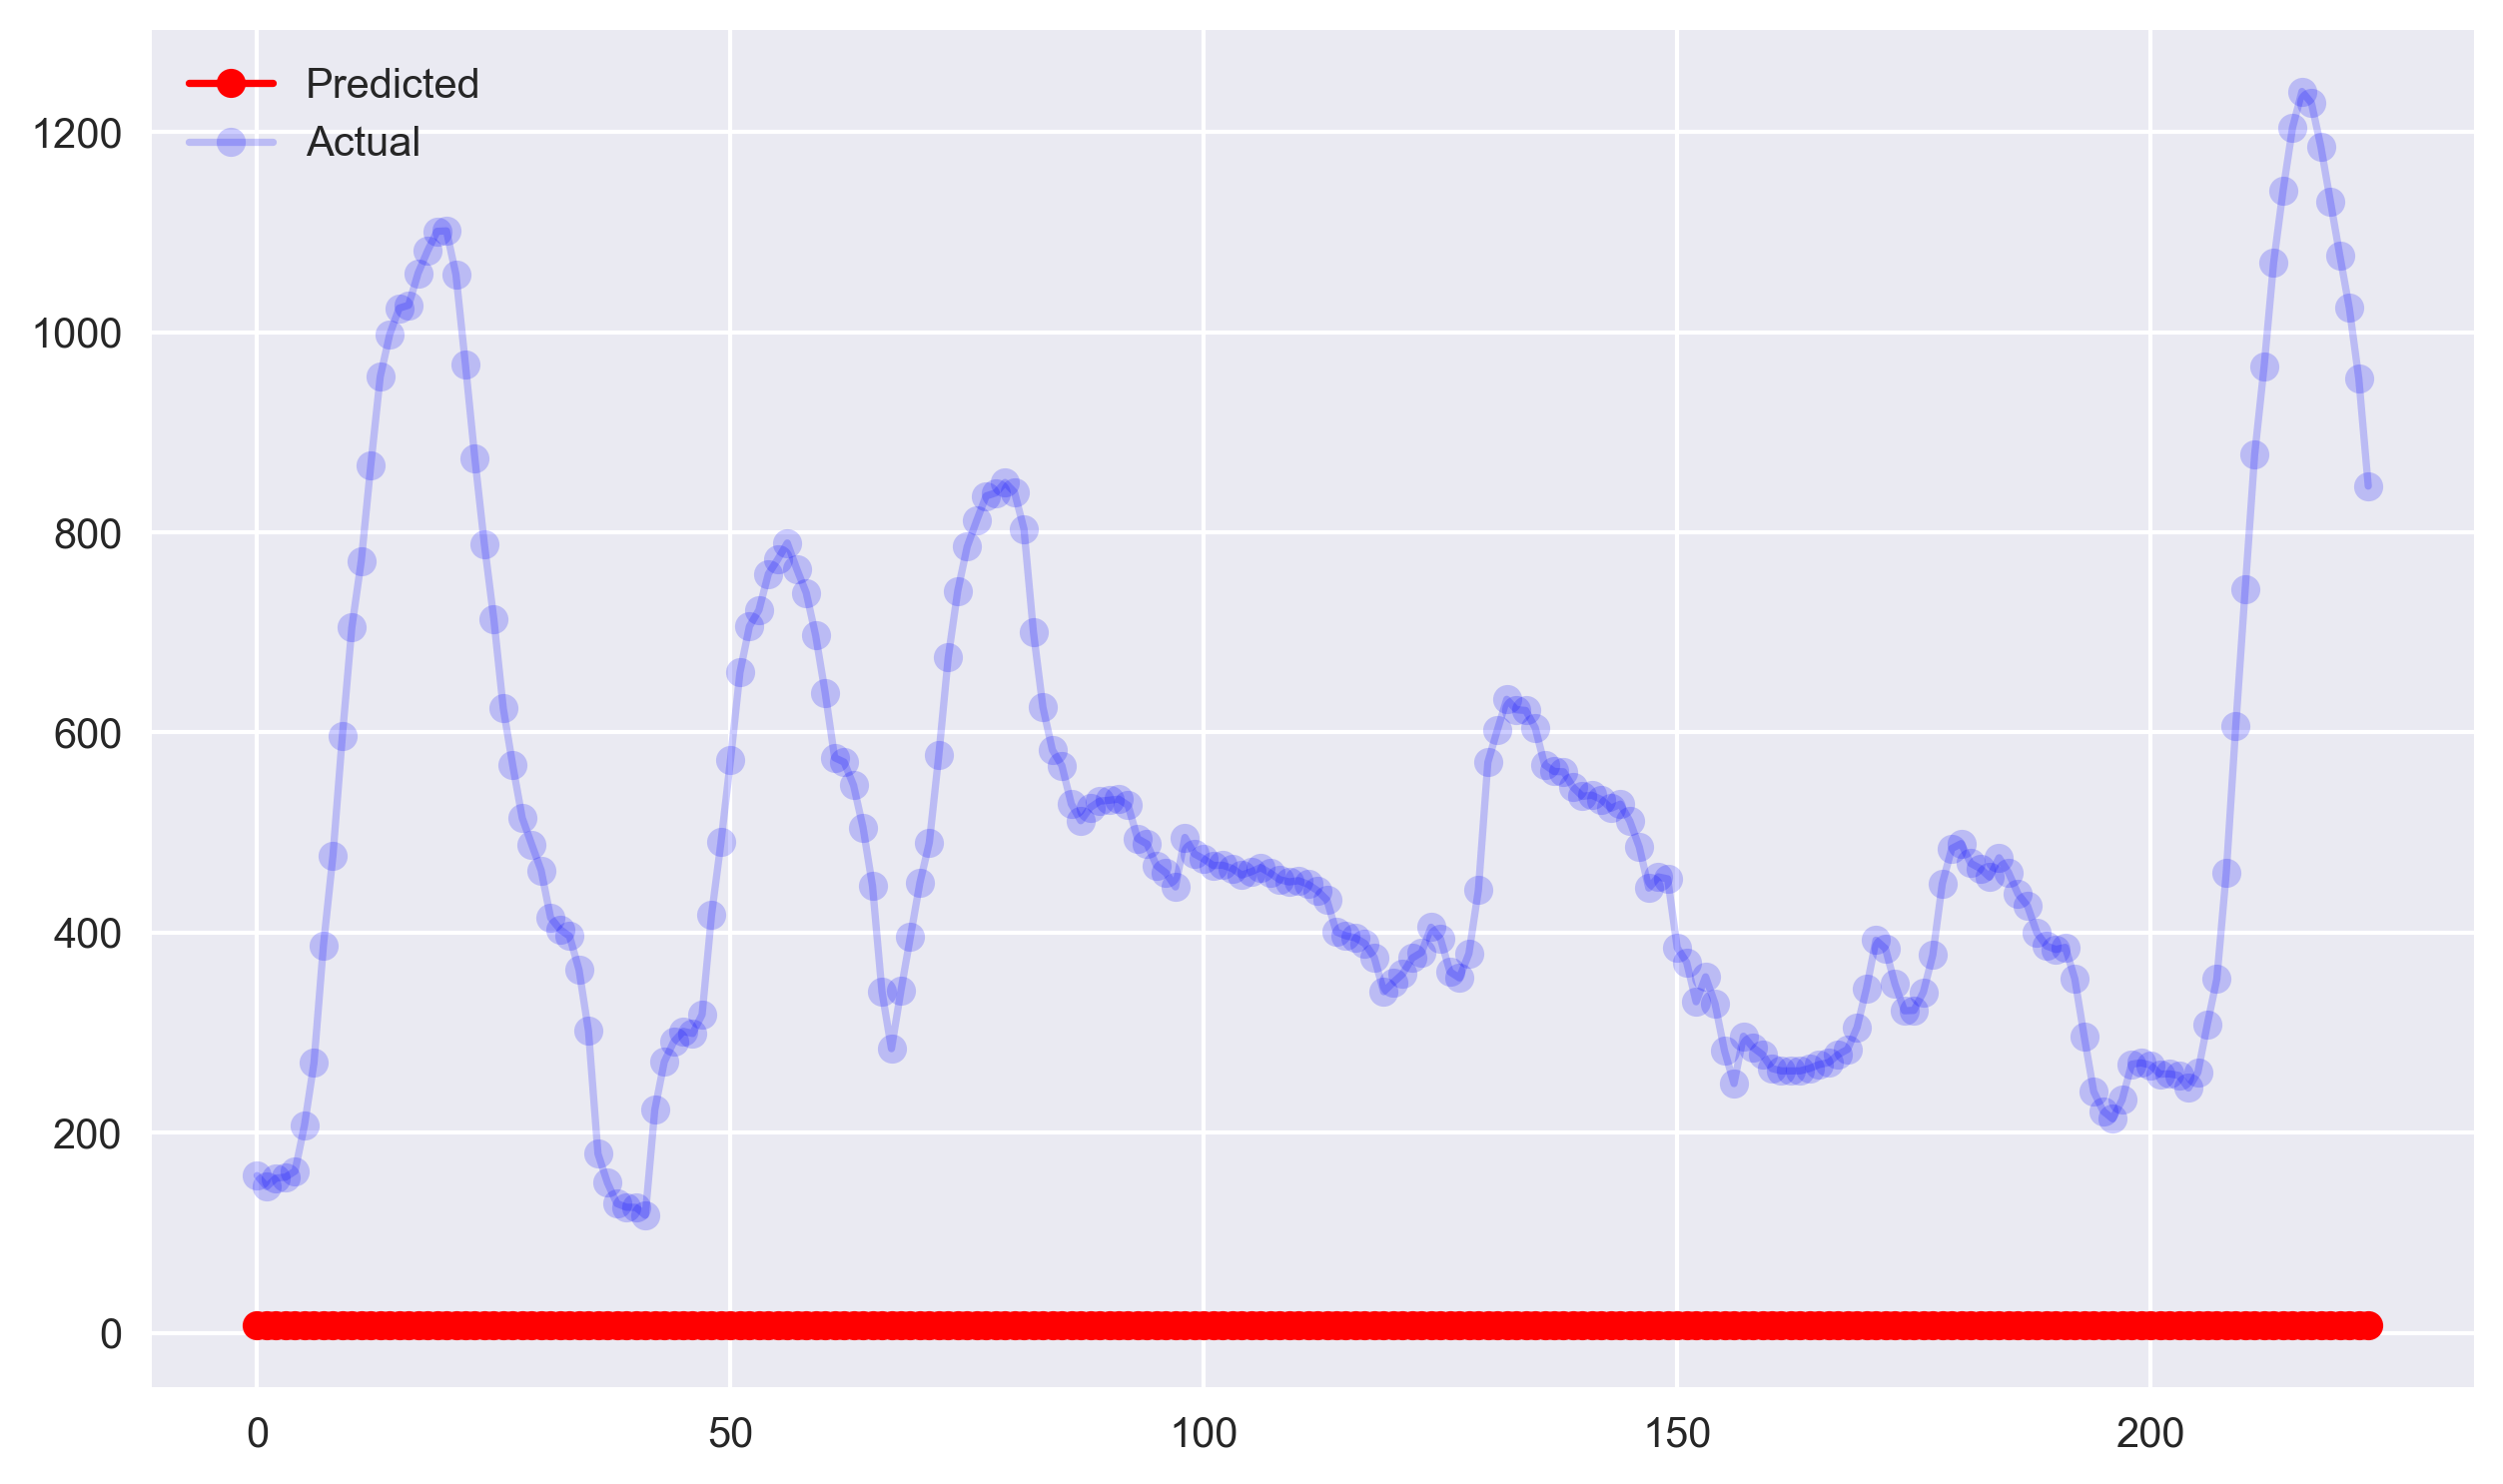

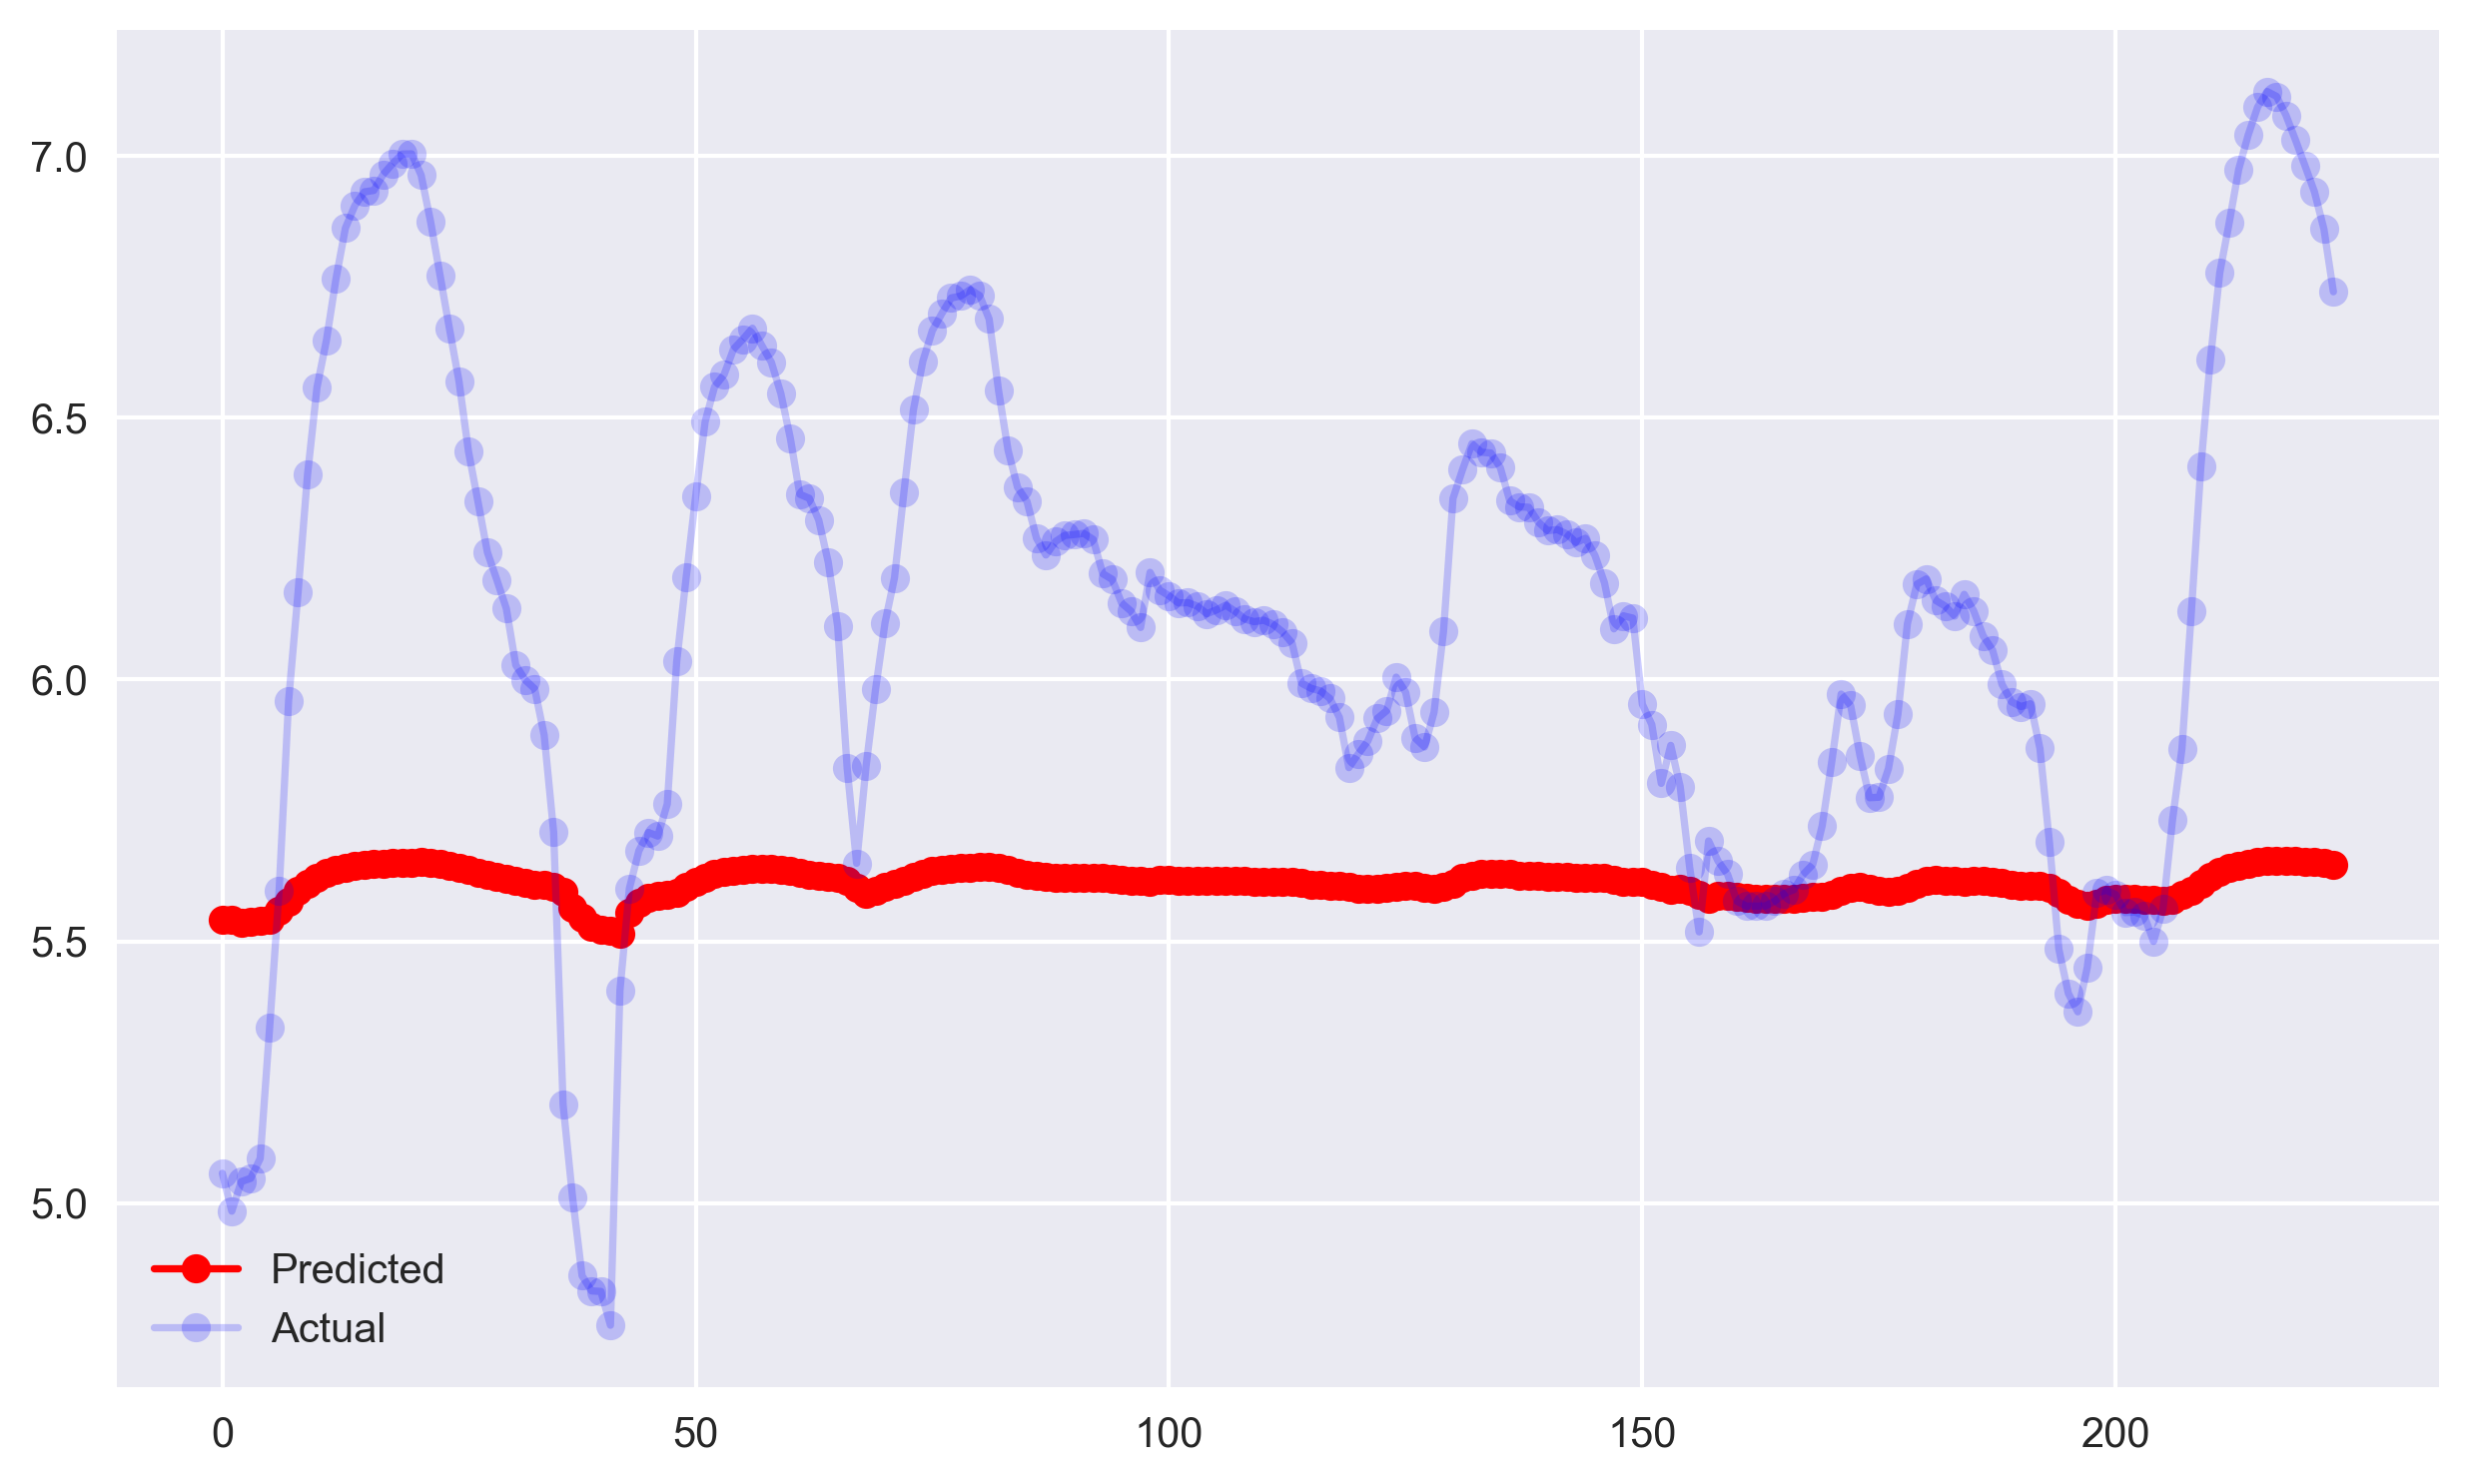

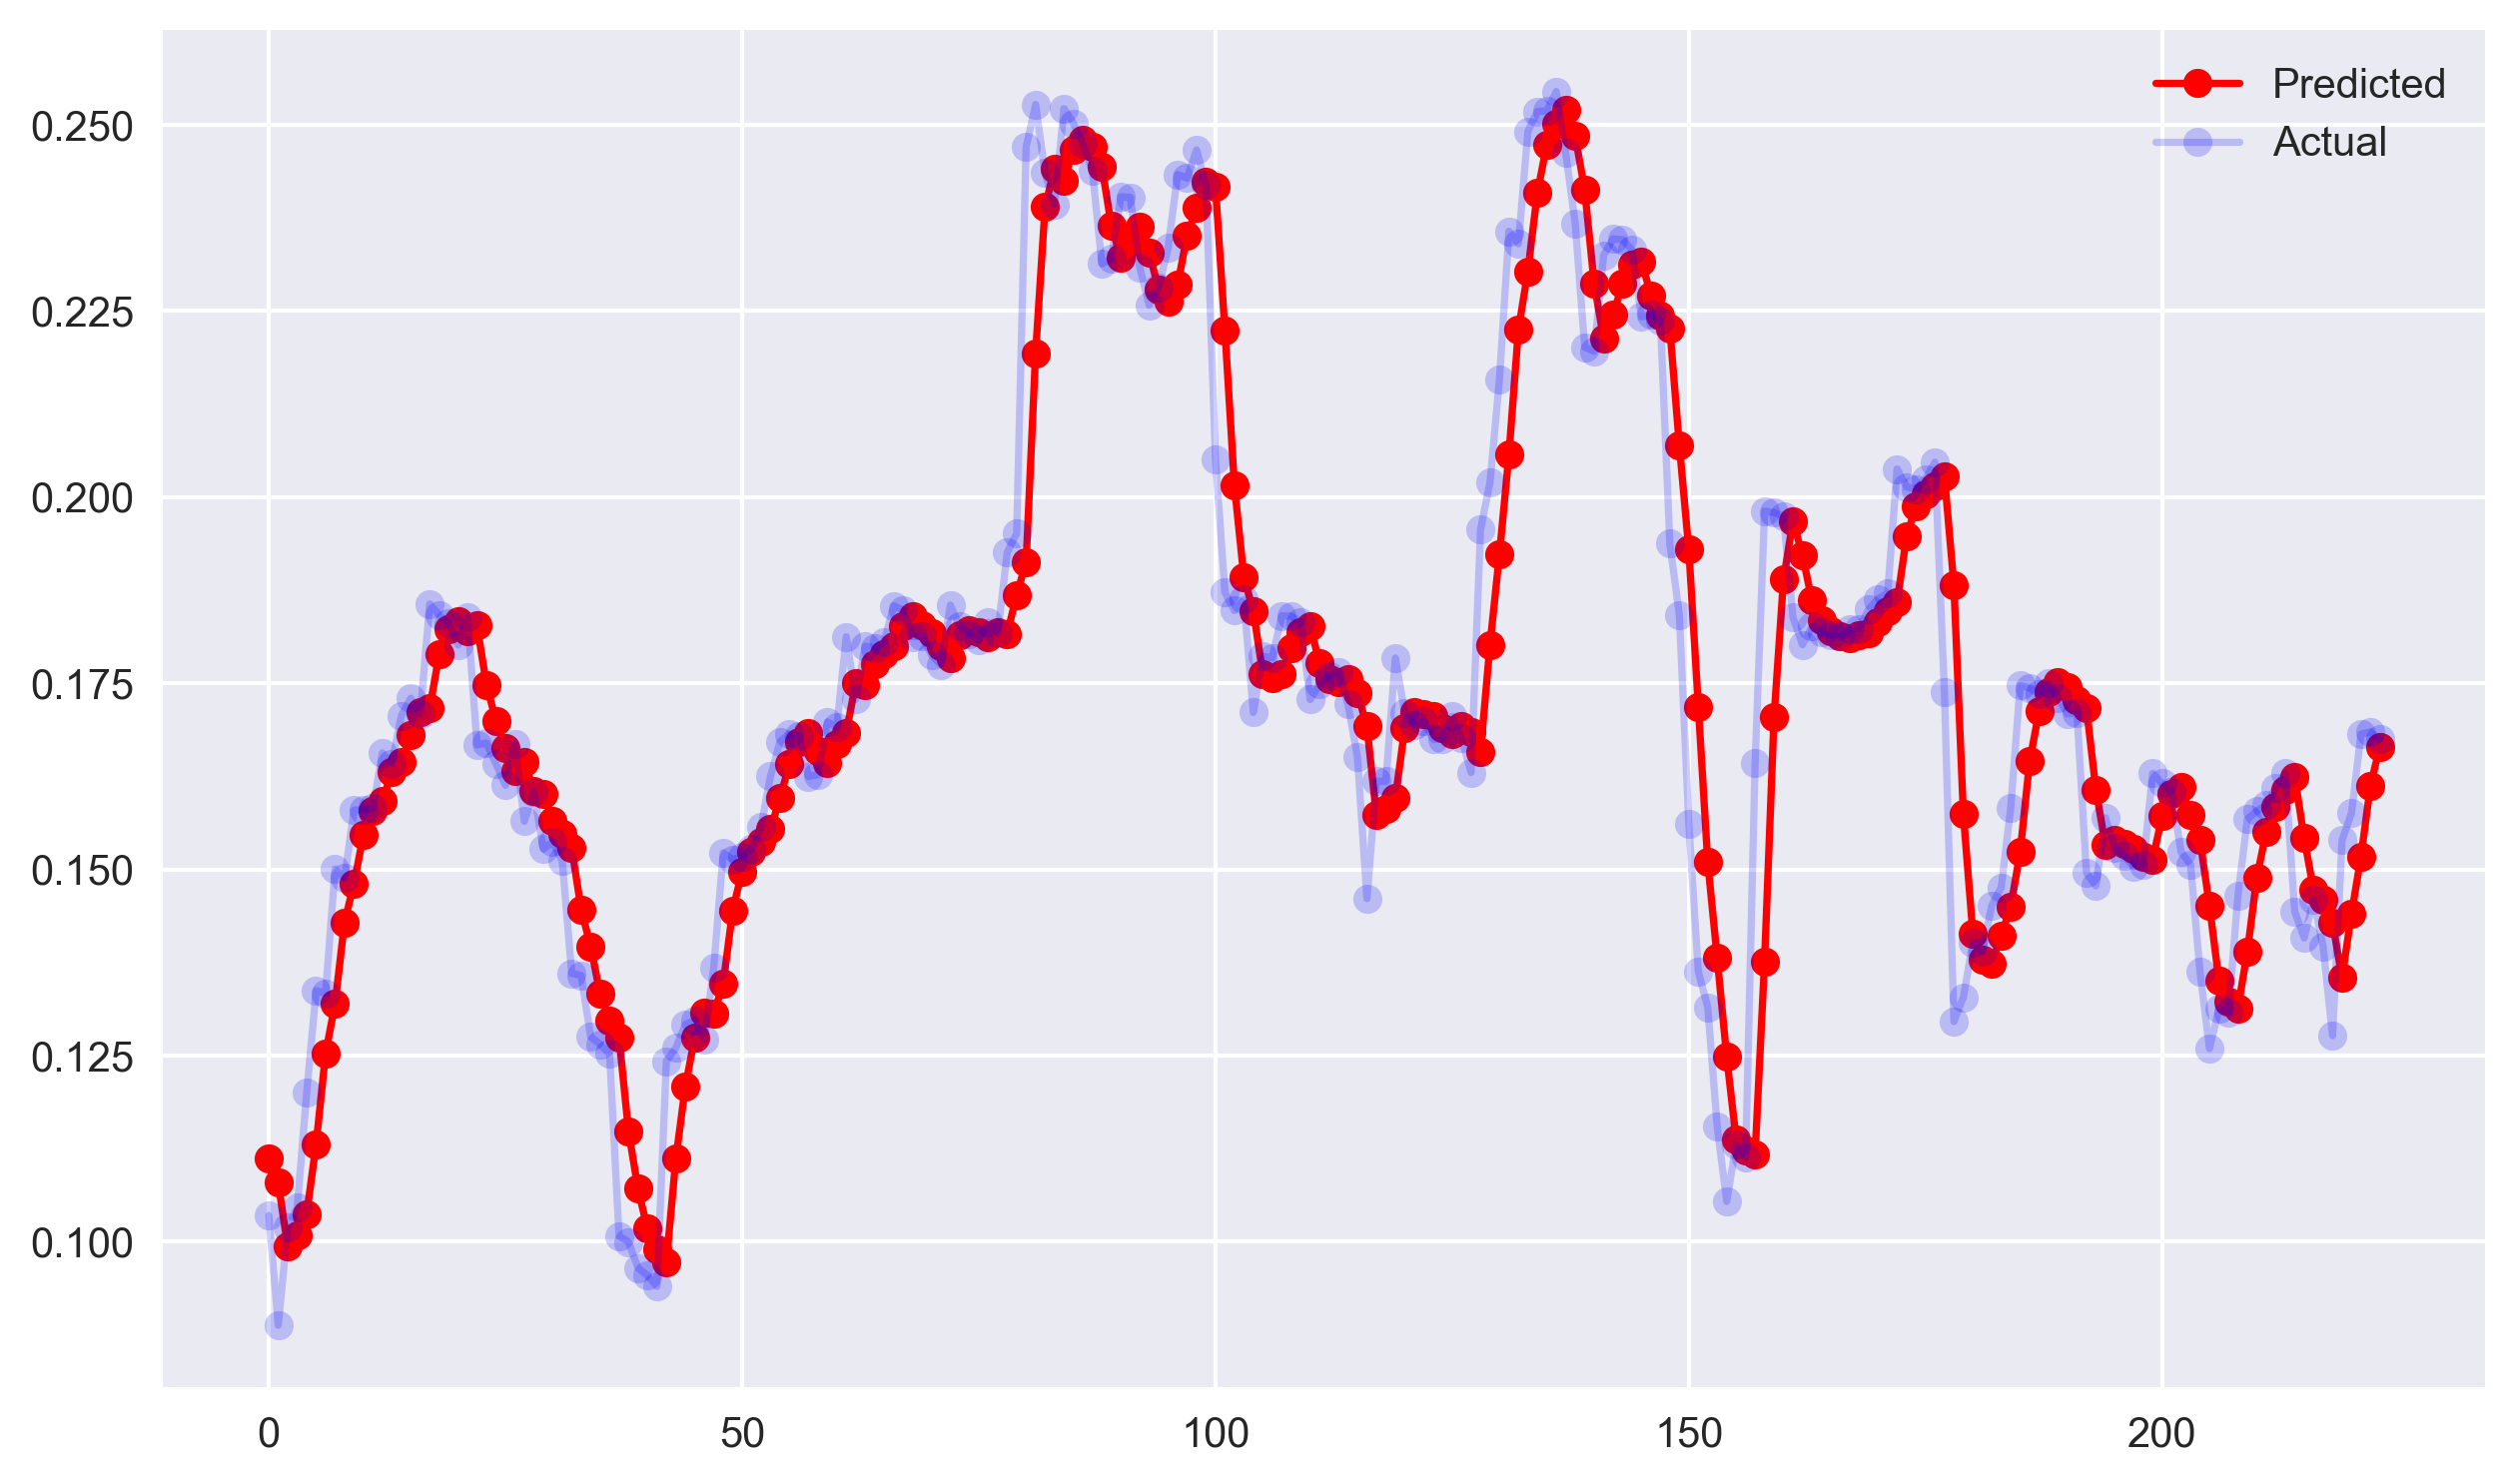

In [80]:
y_hat = []
for i, j in zip(models, X_test):
    y_hat.append(i.predict(j, batch_size=1))

for i, j in zip(y_hat, y_test):
    a_axis = np.arange(0, i.shape[0])
    b_axis = np.arange(0, j.shape[0])
    plt.figure(figsize=(10,6))
    plt.plot(b_axis, i.reshape(i.shape[0],), 'o-', color='red', label='Predicted')
    plt.plot(b_axis, j.reshape(j.shape[0],), 'o-', color='blue', alpha=0.2, label='Actual')
    plt.legend()
    plt.show()

In [81]:
for i in histories:
    print(np.mean(np.sqrt(i.history['val_loss'])))

562.58022994212
0.9732430337063265
0.016332744752558324
